In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import model_trainer, hierarchical_inference
from matplotlib.lines import Line2D
import corner
import pandas as pd
import numpy as np
from lenstronomy.Util.param_util import ellipticity2phi_q

# This allows you to modify the paths in the config to agree with the path you're using
def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/',root_path)
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])

# Generating Hierarchical Inference Plots

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 07/03/2020

__Goals:__ Generate all of the hierarchical inference plots used in the paper analysis.

__Before running this notebook:__ You will have to download and unzip the bnn samples, chains, and datasets that cound be found here (TODO). Because we already have the BNN samples, the model weights are not neccesary. If you would like to reproduce these results starting from the model weights, see the demo notebook on hierarchical inference.

## Create a corner plot to compare training and test distributions

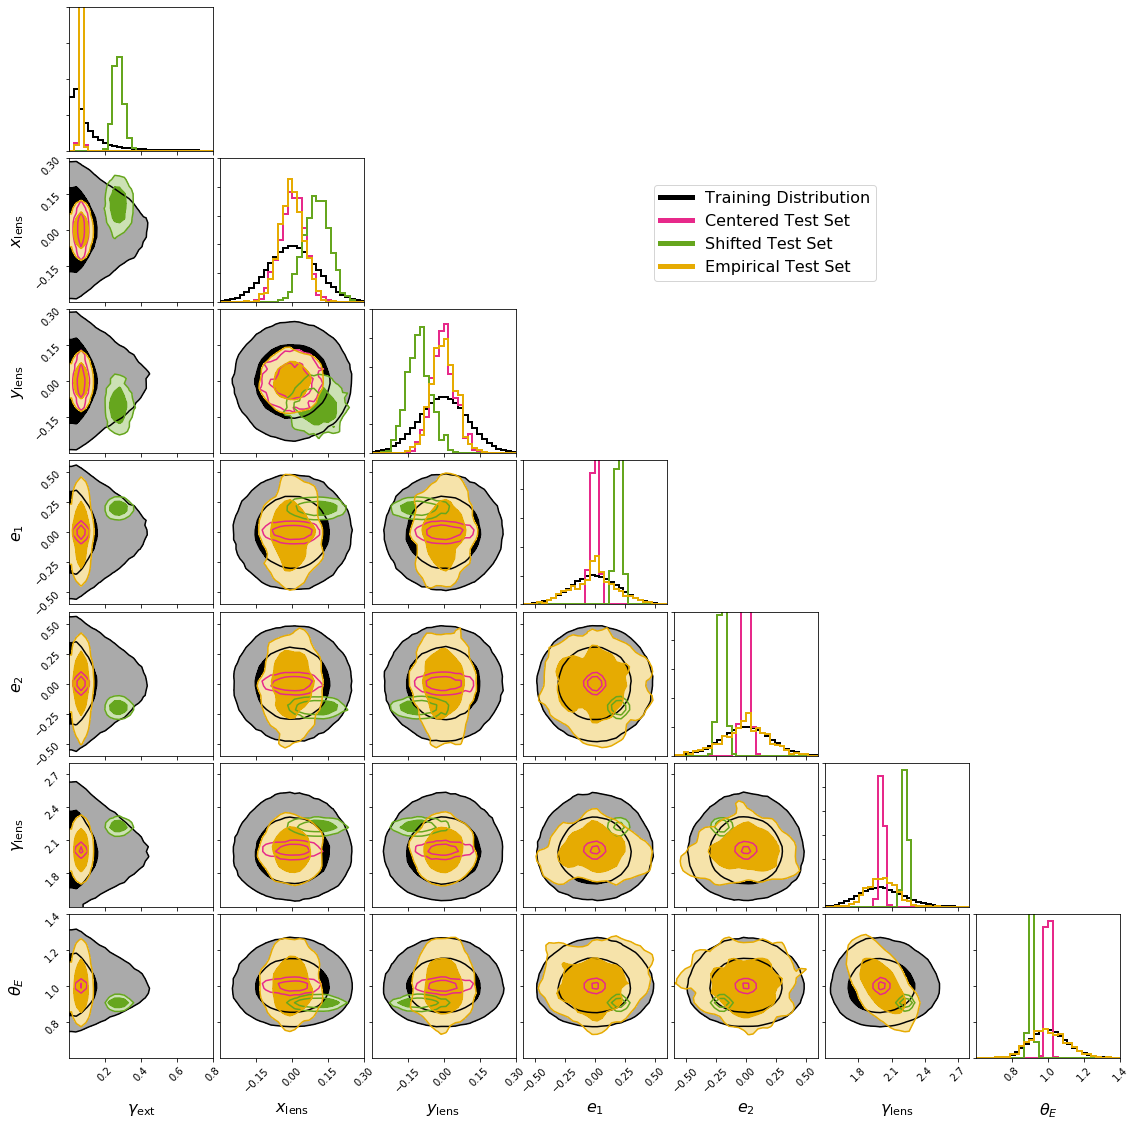

Percent of Training Points in Centered Test Set:  0.14425
Number of Training Points in Centered Test Set:  577
Percent of Training Points in Shifted Test Set:  0.0055000000000000005
Number of Training Points in Shifted Test Set:  22
Percent of Training Points in Empirical Test Set:  21.3015
Number of Training Points in Empirical Test Set:  85206


In [2]:
# Load each one of the metadatas to compare the corner plots
root_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/'
train_metadata = pd.read_csv(root_path+'datasets/train/metadata.csv')
cn_metadata = pd.read_csv(root_path+'datasets/cent_narrow/metadata.csv')
sn_metadata = pd.read_csv(root_path+'datasets/shifted_narrow/metadata.csv')
emp_metadata = pd.read_csv(root_path+'datasets/empirical/metadata.csv')

# Specify the lens_params we're interested in
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
lens_params = cfg['dataset_params']['lens_params']
final_params_print_names = cfg['inference_params']['final_params_print_names']
final_params_print_names.pop(lens_params.index('external_shear_psi_ext'))
final_params_print_names[0] = r'$\gamma_\mathrm{ext}$'
lens_params.pop(lens_params.index('external_shear_psi_ext'))
final_params_print_names[-1] = r'$\theta_E$'

# Get the samples in numpy format
train_samps = train_metadata[lens_params].to_numpy()
cn_samps = cn_metadata[lens_params].to_numpy()
sn_samps = sn_metadata[lens_params].to_numpy()
emp_samps = emp_metadata[lens_params].to_numpy()

# Generate the plot
figure= None
color_map_distributions = ['000000','#e7298a','#66a61e','#e6ab02']
plot_limits = [[0,0.8],[-0.3,0.3],[-0.3,0.3],[-0.6,0.6],[-0.6,0.6],[1.5,2.8],[0.6,1.4]]
hist_limit = [20,10,10,10,10,15,20]
smooth = 0.5
fontsize = 16
hist_kwargs = {'density':True,'color':color_map_distributions[0],'lw':2}
figure = corner.corner(train_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[0],levels=[0.68,0.95],
                       fill_contours=True,fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map_distributions[1]
figure = corner.corner(cn_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[1],levels=[0.68,0.95],
                       fill_contours=True,fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map_distributions[2]
figure = corner.corner(sn_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[2],levels=[0.68,0.95],
                       fill_contours=True,fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map_distributions[3]
figure = corner.corner(emp_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[3],levels=[0.68,0.95],
                       fill_contours=True,fig=figure,range=plot_limits,smooth=smooth*2,hist_kwargs=hist_kwargs)
handles = [Line2D([0], [0], color=color_map_distributions[0], lw=5),
           Line2D([0], [0], color=color_map_distributions[1], lw=5),
           Line2D([0], [0], color=color_map_distributions[2], lw=5),
           Line2D([0], [0], color=color_map_distributions[3], lw=5)]
figure.legend(handles,[r'Training Distribution', r'Centered Test Set',r'Shifted Test Set',r'Empirical Test Set'],
              loc=(0.575,0.75),fontsize=fontsize)

axes = np.array(figure.axes).reshape((len(lens_params),len(lens_params)))
for i in range(len(lens_params)):
    axes[i,i].set_ylim(0,hist_limit[i])
    
plt.savefig('figures/distribution_comp.pdf')
plt.show()

print('Percent of Training Points in Centered Test Set: ',
      np.mean(np.prod((train_samps > np.min(cn_samps,axis=0)) * (train_samps < np.max(cn_samps,axis=0)),axis=1))*100)
print('Number of Training Points in Centered Test Set: ',
      np.sum(np.prod((train_samps > np.min(cn_samps,axis=0)) * (train_samps < np.max(cn_samps,axis=0)),axis=1)))
print('Percent of Training Points in Shifted Test Set: ',
      np.mean(np.prod((train_samps > np.min(sn_samps,axis=0)) * (train_samps < np.max(sn_samps,axis=0)),axis=1))*100)
print('Number of Training Points in Shifted Test Set: ',
      np.sum(np.prod((train_samps > np.min(sn_samps,axis=0)) * (train_samps < np.max(sn_samps,axis=0)),axis=1)))
print('Percent of Training Points in Empirical Test Set: ',
      np.mean(np.prod((train_samps > np.min(emp_samps,axis=0)) * (train_samps < np.max(emp_samps,axis=0)),axis=1))
      *100)
print('Number of Training Points in Empirical Test Set: ',
      np.sum(np.prod((train_samps > np.min(emp_samps,axis=0)) * (train_samps < np.max(emp_samps,axis=0)),axis=1)))


## Compare performance of all three model types on the centered narrow test distribution

First, we start by loading the files we'll need for our analysis

In [3]:
# Here we'll define a few lists we'll use throughout plotting
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\log (\gamma_\mathrm{lens})}$',r'$\sigma_{\log (\gamma_\mathrm{lens})}$',
                         r'$\mu_{\log (\theta_E)}$',r'$\sigma_{\log (\theta_E)}$']
param_plot_names = [r'$\gamma_\mathrm{ext}$', r'$\psi_\mathrm{ext}$',r'$x_\mathrm{lens}$',
            r'$y_\mathrm{lens}$',r'$e_1$',r'$e_2$',r'$\gamma_\mathrm{lens}$',r'$\theta_E$']

In [4]:
# Diagonal model 30% dropout chains on centered test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/cent_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_cn'
num_samples = 1000
n_walkers = 50

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)

# We can load the chains for nn1_hr on the centered narrow distribution
save_path_samples_nn1_hr = root_path + 'hierarchical_results/cn_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
# Same goes for the samples
n_walkers = 50
save_path_chains_nn1_hr = root_path + 'hierarchical_results/cn_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining two distributions
# Full Model 0.1% Dropout
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn2_slr = root_path + 'hierarchical_results/cn_nn2_slr_samps/'
hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
save_path_chains_nn2_slr = root_path + 'hierarchical_results/cn_nn2_slr.h5'
hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn2_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn2_slr_samps/
Loading samples from /Users/sebwagner/Doc

We can quickly check that each of our chains are converged. These lines are commented out to avoid extending the length of notebook, but you should run them at least once to convince yourself the chains are converged!

In [5]:
burnin = 8000
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

Our main parameter of interest is the power-law mass slope so we'll focus on that for the posteriors of the centered narrow distribution. First we generate the 1D plots for our three models. We do not use these in the paper so they are commented out.

In [6]:
# color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
# bnn_name = 'Diagonal BNN'
# save_fig_path = 'figures/cn_gamma_lens_1d_diag.pdf'
# hier_infer_nn1.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

# color_map[1] = "#d95f02"
# bnn_name = 'Full BNN'
# save_fig_path = 'figures/cn_gamma_lens_1d_full.pdf'
# hier_infer_nn2.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

# color_map[1] = "#7570b3" 
# bnn_name = 'GMM BNN'
# save_fig_path = 'figures/cn_gamma_lens_1d_gmm.pdf'
# hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

Together with the 1d distributions, we may also be interested in comparing the posteriors for the two hyperparameters we've inferred hierarchically for gamma lens.

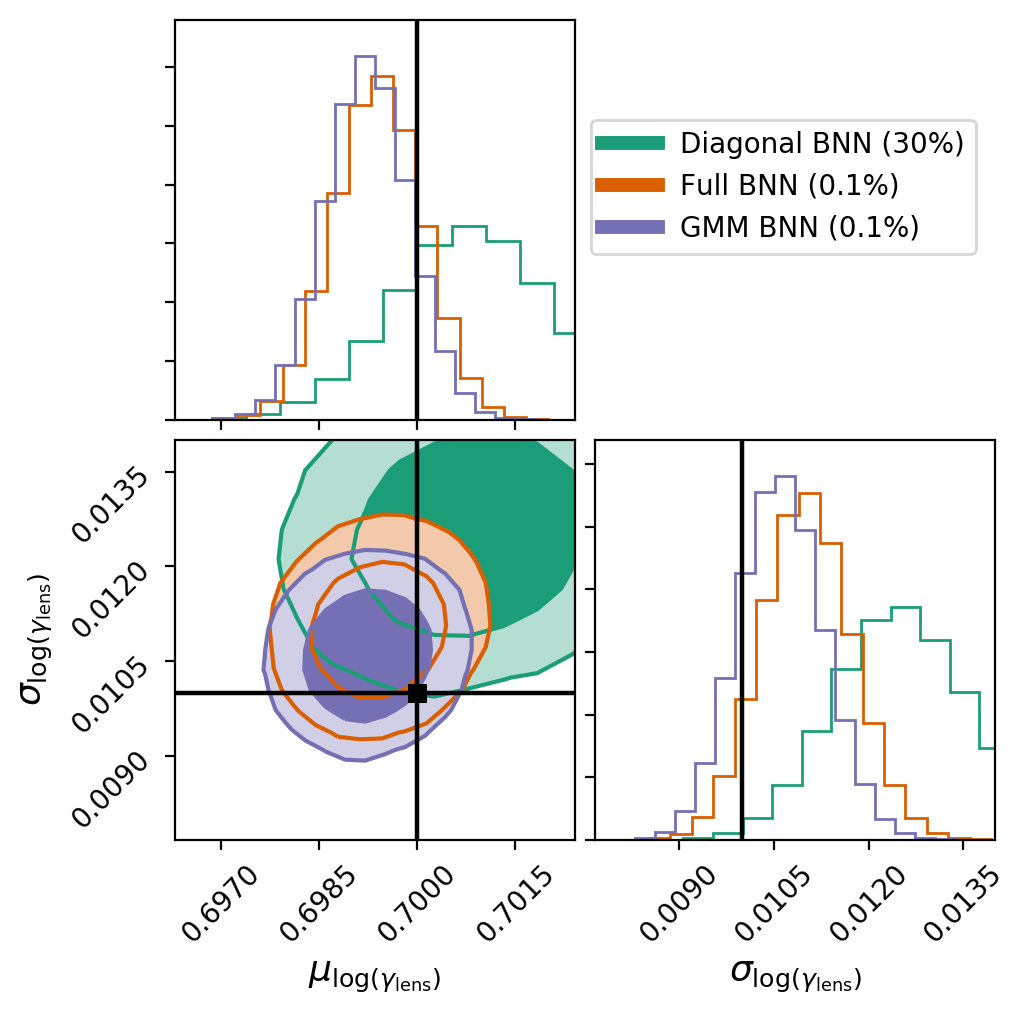

In [7]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77')
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_lens_2d_hyps.pdf')
plt.show(figure)

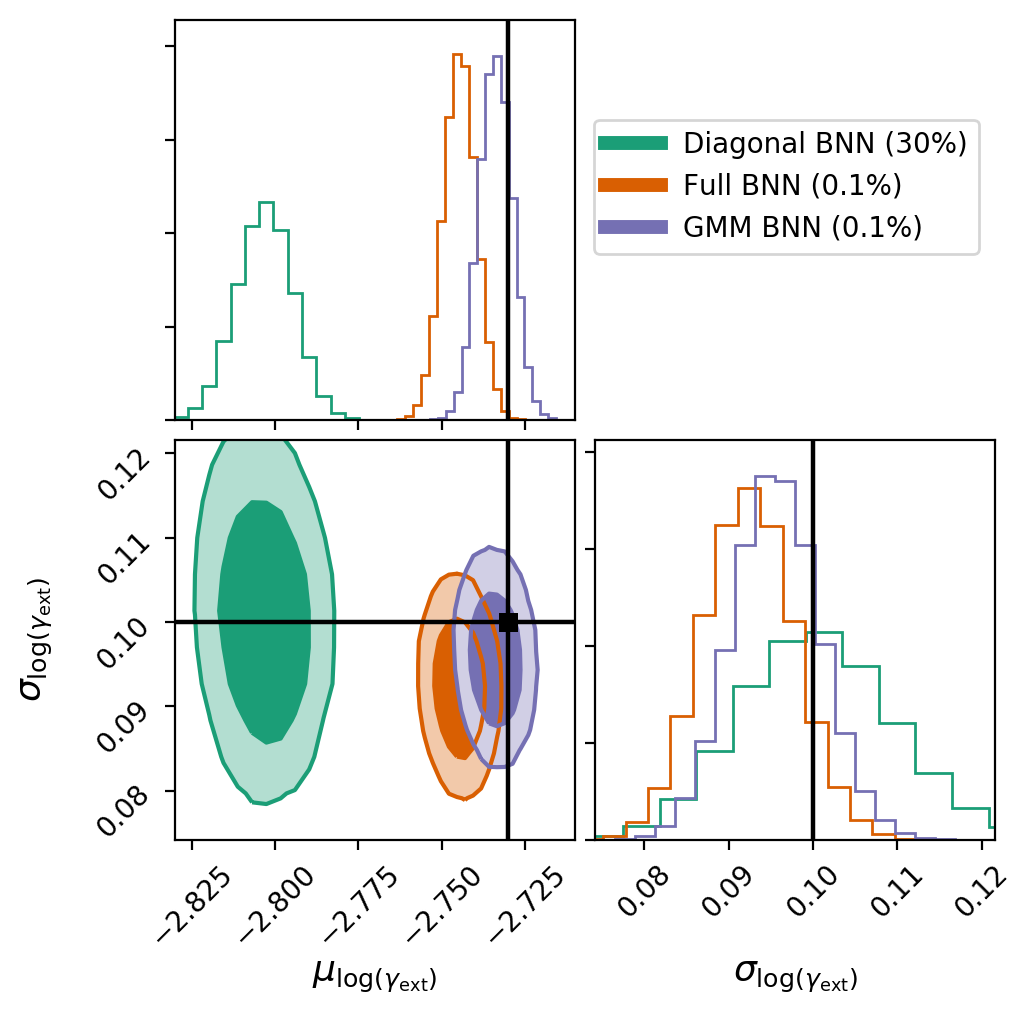

In [8]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77')
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure)

# Modify the axis limits manually to get the Diagonal posterior
figure.axes[0].set_xlim([-2.83,-2.71])
figure.axes[2].set_xlim([-2.83,-2.71])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_ext_2d_hyps.pdf')
plt.show(figure)

We can also examine how the hierarchical reweighting impacts the calibration of our BNN on the test set.

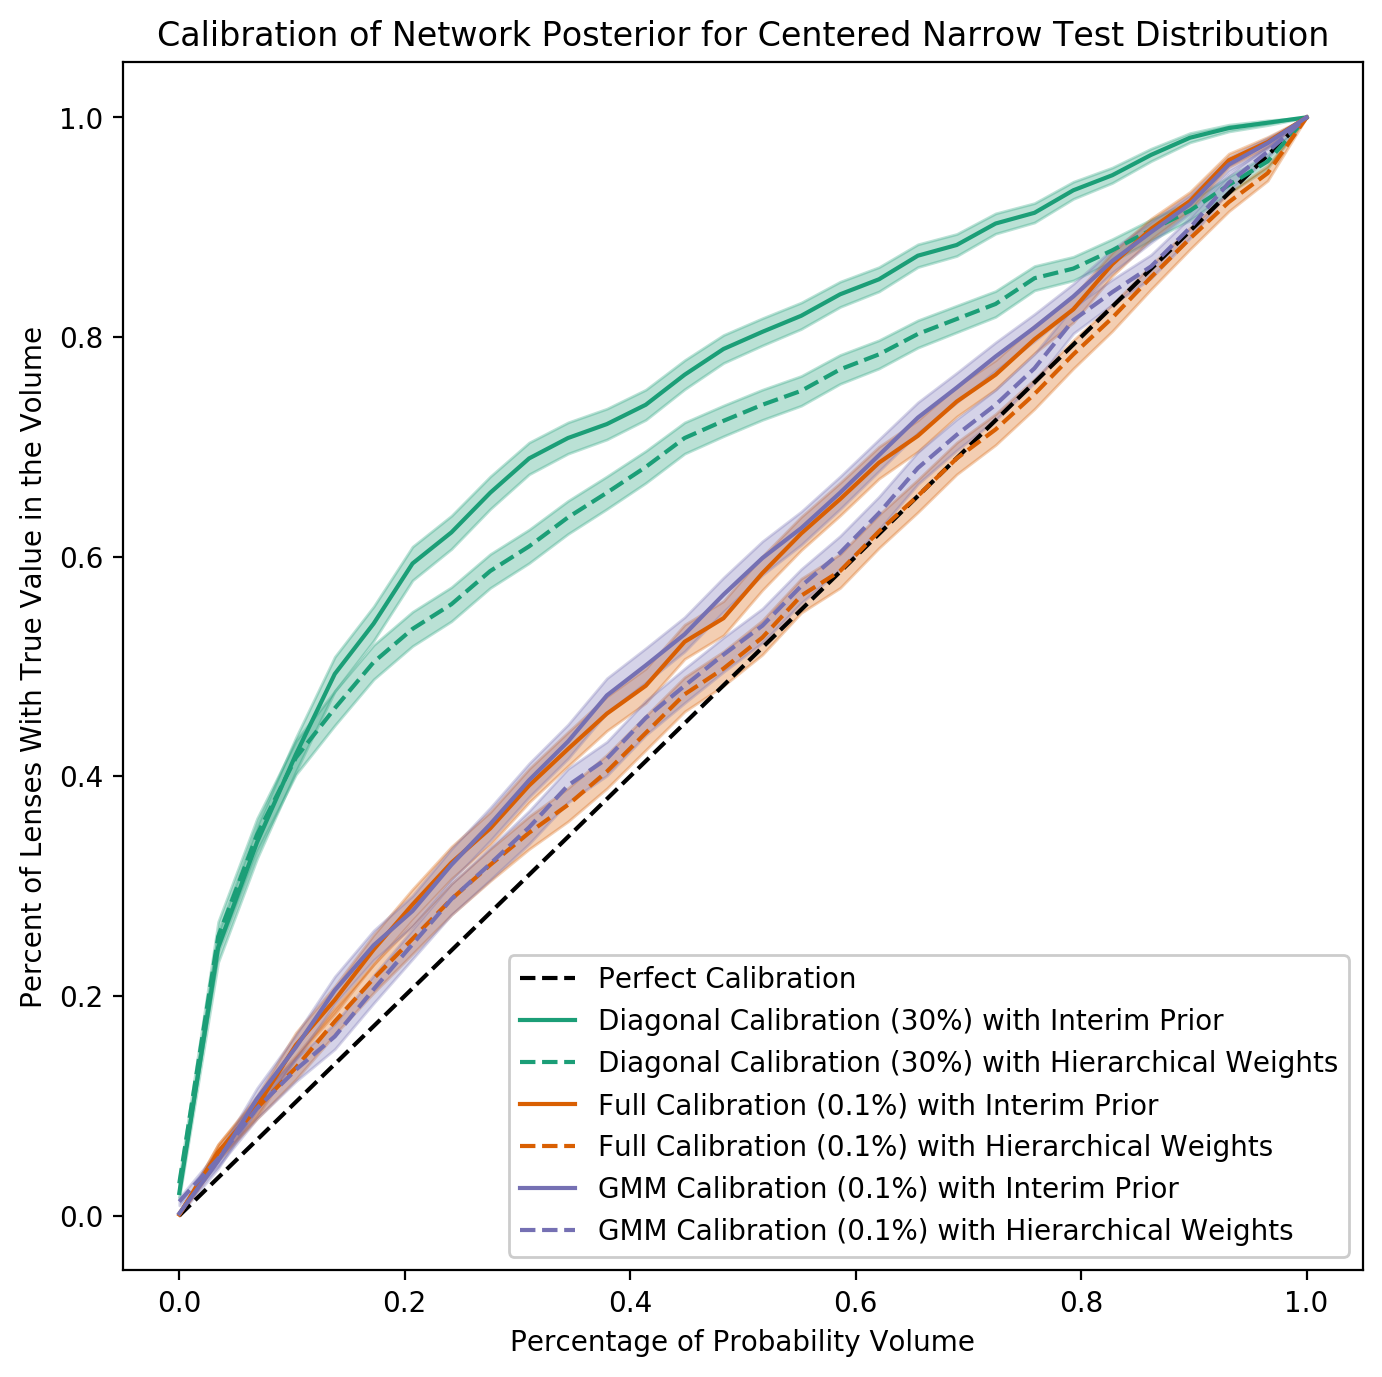

In [9]:
color_map = np.array(['#000000','#1b9e77','#d95f02','#7570b3','#e7298a'])
legend=[r'Perfect Calibration',r'Diagonal Calibration (30%) with Interim Prior',
        r'Diagonal Calibration (30%) with Hierarchical Weights',r'Full Calibration (0.1%) with Interim Prior',
        r'Full Calibration (0.1%) with Hierarchical Weights',r'GMM Calibration (0.1%) with Interim Prior',
        r'GMM Calibration (0.1%) with Hierarchical Weights']
ls_list =['-','--']
n_perc_points = 30
n_p_omega_samps = 100
fig = hier_infer_nn1.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,1,1]],legend=None,ls_list=ls_list)
fig = hier_infer_nn2.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,2,2]],legend=None,ls_list=ls_list,
                                                 figure=fig)
fig = hier_infer_nn3.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,3,3]],legend=None,ls_list=ls_list,
                                                 figure=fig)

plt.legend(legend,loc=0,framealpha=1.0)
plt.title('Calibration of Network Posterior for Centered Narrow Test Distribution')
plt.xlabel('Percentage of Probability Volume')
plt.ylabel('Percent of Lenses With True Value in the Volume')
plt.savefig('figures/calibration_cn.pdf')
plt.show()

Finally, we can plot a comparison of the input distribution to the reweighted BNN outputs. This is less informative of individual parameter performance than the plots we've made so far, but it helps form a better picture of the overall shift if the population inference.

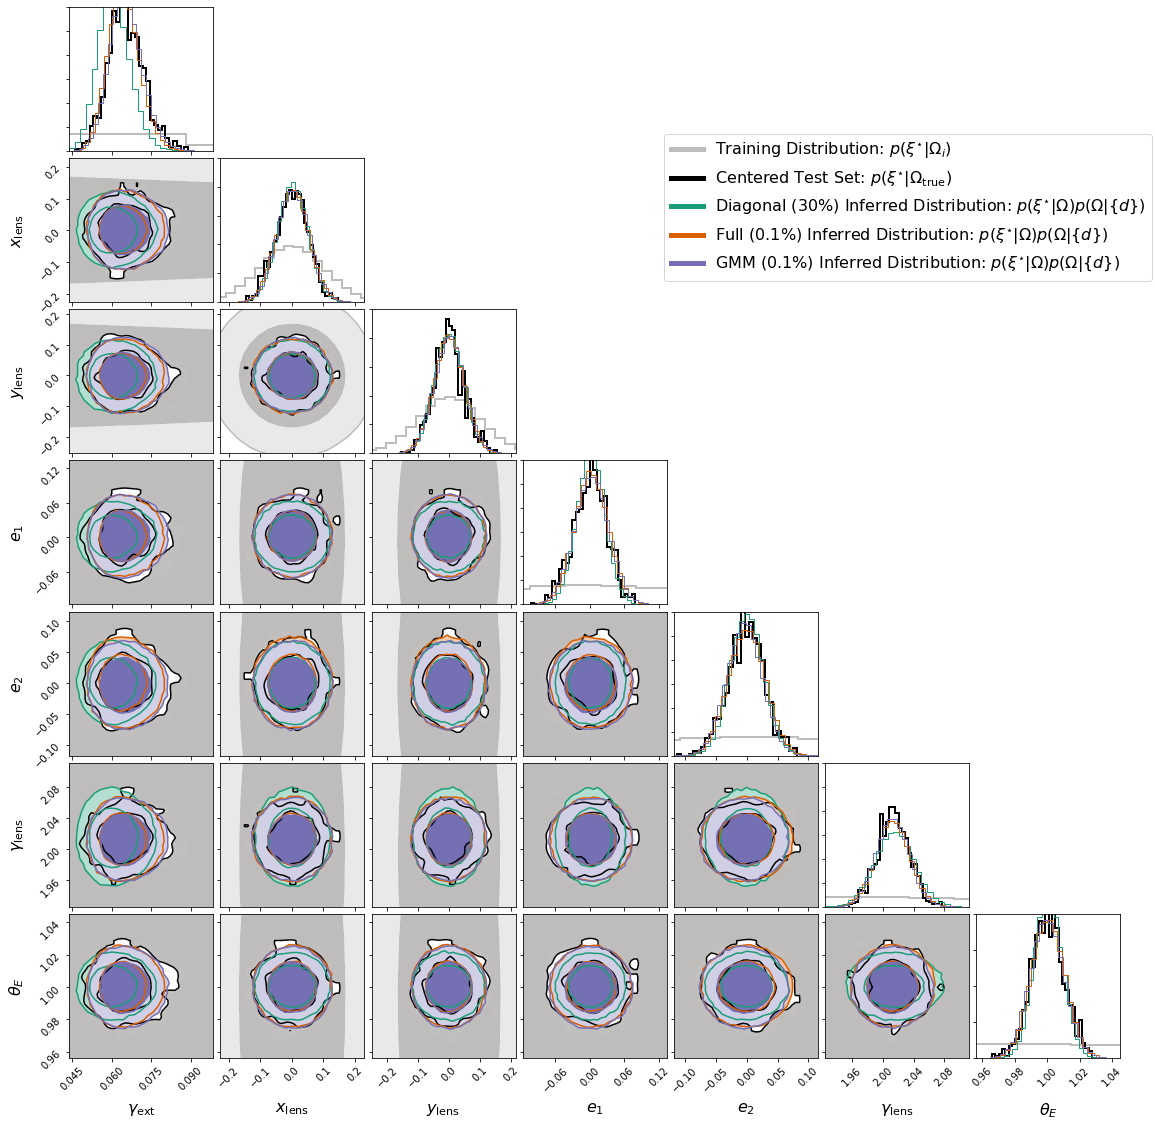

In [10]:
# Most of this code mirrors the code used to plot the distributions in the first panel. The only change is that now
# we're only plotting one test distribution and we're plotting the GMM inferred distribution
figure= None
color_map_distributions = ['#bfbdbc','#000000','#1b9e77','#d95f02','#7570b3']
plot_limits = None#[[0.03,0.09],[-0.3,0.3],[-0.3,0.3],[-0.15,0.15],[-0.15,0.15],[1.9,2.1],[0.95,1.05]]
hist_limit = [60,10,10,15,15,30,40]
# We need to smooth our test distribution because it has few samples. Note that no smoothing is applied to the 
# plotting of the inferred distribution.
smooth = 1.2
fontsize = 16
hist_kwargs = {'density':True,'color':color_map_distributions[0],'lw':2}
figure = corner.corner(train_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[0],levels=[0.68,0.95],
                       fill_contours=True,fig=figure,hist_kwargs=hist_kwargs,smooth=smooth)
hist_kwargs['color']=color_map_distributions[1]
figure = corner.corner(cn_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[1],levels=[0.68,0.95],
                       fill_contours=False,fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hier_infer_nn1.plot_parameter_distribtuion(burnin,lens_params,n_p_omega_samps=100,samps_per_omega=1000,figure=figure,
                                          color=color_map_distributions[2],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names)
hier_infer_nn2.plot_parameter_distribtuion(burnin,lens_params,n_p_omega_samps=100,samps_per_omega=1000,figure=figure,
                                          color=color_map_distributions[3],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names)
hier_infer_nn3.plot_parameter_distribtuion(burnin,lens_params,n_p_omega_samps=100,samps_per_omega=1000,figure=figure,
                                          color=color_map_distributions[4],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names)
handles = [Line2D([0], [0], color=color_map_distributions[0], lw=5),
           Line2D([0], [0], color=color_map_distributions[1], lw=5),
           Line2D([0], [0], color=color_map_distributions[2], lw=5),
           Line2D([0], [0], color=color_map_distributions[3], lw=5),
           Line2D([0], [0], color=color_map_distributions[4], lw=5)]
figure.legend(handles,[r'Training Distribution: $p(\xi^{\star}|\Omega_i)$', 
                       r'Centered Test Set: $p(\xi^{\star}|\Omega_\mathrm{true})$',
                       r'Diagonal (30%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $',
                       r'Full (0.1%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $',
                       r'GMM (0.1%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $'],
                       loc=(0.575,0.75),fontsize=fontsize)

axes = np.array(figure.axes).reshape((len(lens_params),len(lens_params)))
for i in range(len(lens_params)):
    axes[i,i].set_ylim(0,hist_limit[i])
    
plt.savefig('figures/cn_distribution_comp.pdf')
plt.show()

## Compare performance of all three model types on the shifted narrow test distribution

In [11]:
# Diagonal model 30% dropout chains on shifted test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/shifted_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/shifted_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_sn'

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn1_hr = root_path + 'hierarchical_results/sn_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
save_path_chains_nn1_hr = root_path + 'hierarchical_results/sn_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining two distributions
# Full Model 0.1% Dropout
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn2_slr = root_path + 'hierarchical_results/sn_nn2_slr_samps/'
hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
save_path_chains_nn2_slr = root_path + 'hierarchical_results/sn_nn2_slr.h5'
hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/sn_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/sn_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/tf_record_sn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn2_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/shifted_narrow/tf_record_sn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/sn_nn2_slr_samps/
Loading samples from /Users/sebwagn

Check that the chains have converged.

In [12]:
burnin = 8000
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

As before, our main parameter of interest is the power-law mass slope.

In [13]:
# color_map = ["#253494",'#1b9e77',"#41b6c4","#2c7fb8"]
# bnn_name = 'Diagonal BNN'
# save_fig_path = 'figures/sn_gamma_lens_1d_diag.pdf'
# hier_infer_nn1.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

# color_map[1] = "#d95f02"
# bnn_name = 'Full BNN'
# save_fig_path = 'figures/sn_gamma_lens_1d_full.pdf'
# hier_infer_nn2.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

# color_map[1] = "#7570b3" 
# bnn_name = 'GMM BNN'
# save_fig_path = 'figures/sn_gamma_lens_1d_gmm.pdf'
# hier_infer_nn3.plot_distributions(burnin,param_plot_names,color_map=color_map,bnn_name=bnn_name,
#                                   plot_param='lens_mass_gamma',save_fig_path=save_fig_path)

Given that the shifted distribution involves a ~3 sigma shift, our hierarchical reconstruction goes surprisingly well. It's worth looking at the same 2d contours as before to compare our models.

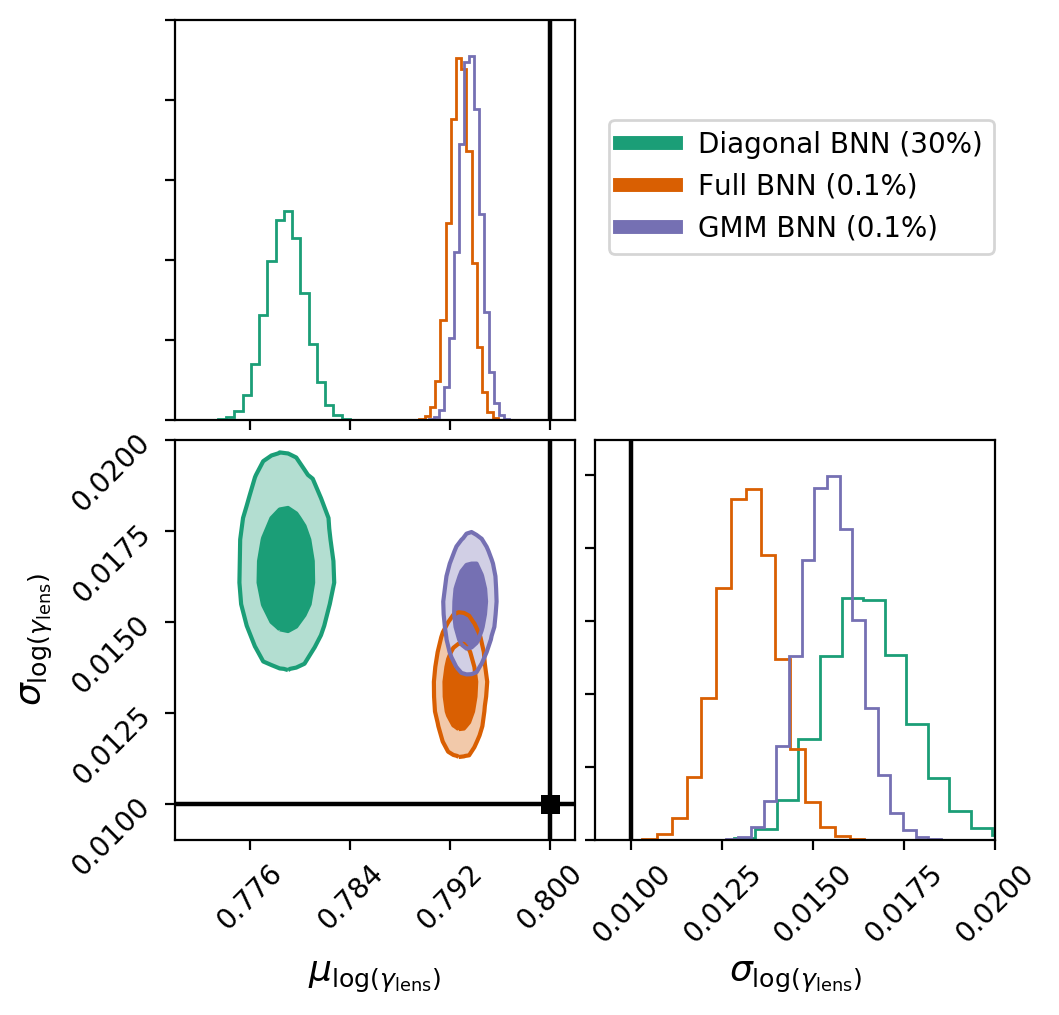

In [14]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = None#[[0.77,0.802],[0.009,0.02]]
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Modify the axis limits manually to get the Diagonal posterior
figure.axes[0].set_xlim([0.77,0.802])
figure.axes[2].set_xlim([0.77,0.802])
figure.axes[2].set_ylim([0.009,0.02])
figure.axes[3].set_xlim([0.009,0.02])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/sn_gamma_lens_2d_hyps.pdf')
plt.show(figure)

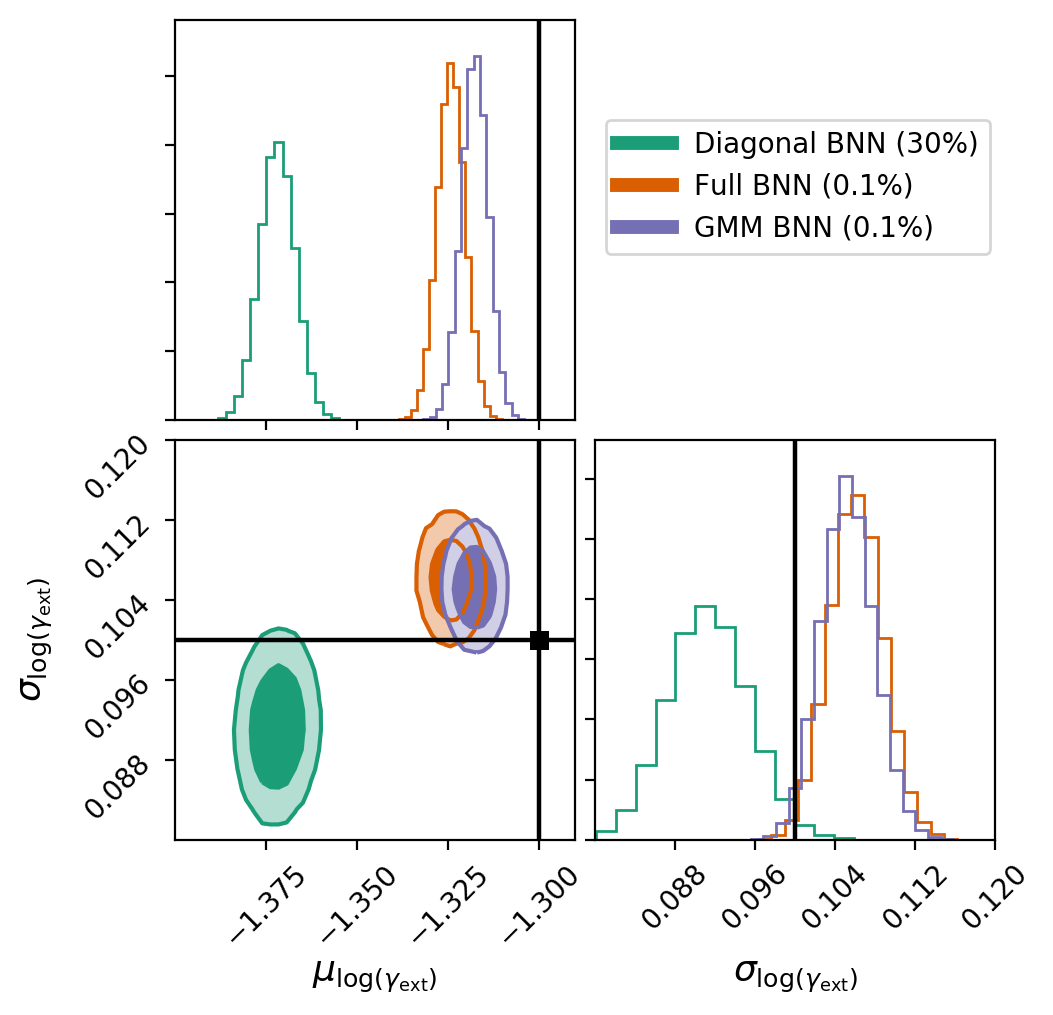

In [15]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
plot_range = None
figure = hier_infer_nn1.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn2.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Modify the axis limits manually to get the Diagonal posterior
figure.axes[0].set_xlim([-1.4,-1.29])
figure.axes[2].set_xlim([-1.4,-1.29])
figure.axes[2].set_ylim([0.08,0.12])
figure.axes[3].set_xlim([0.08,0.12])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))

plt.savefig('figures/sn_gamma_ext_2d_hyps.pdf')
plt.show(figure)

We can check how this impacts our calibration as we have done before.

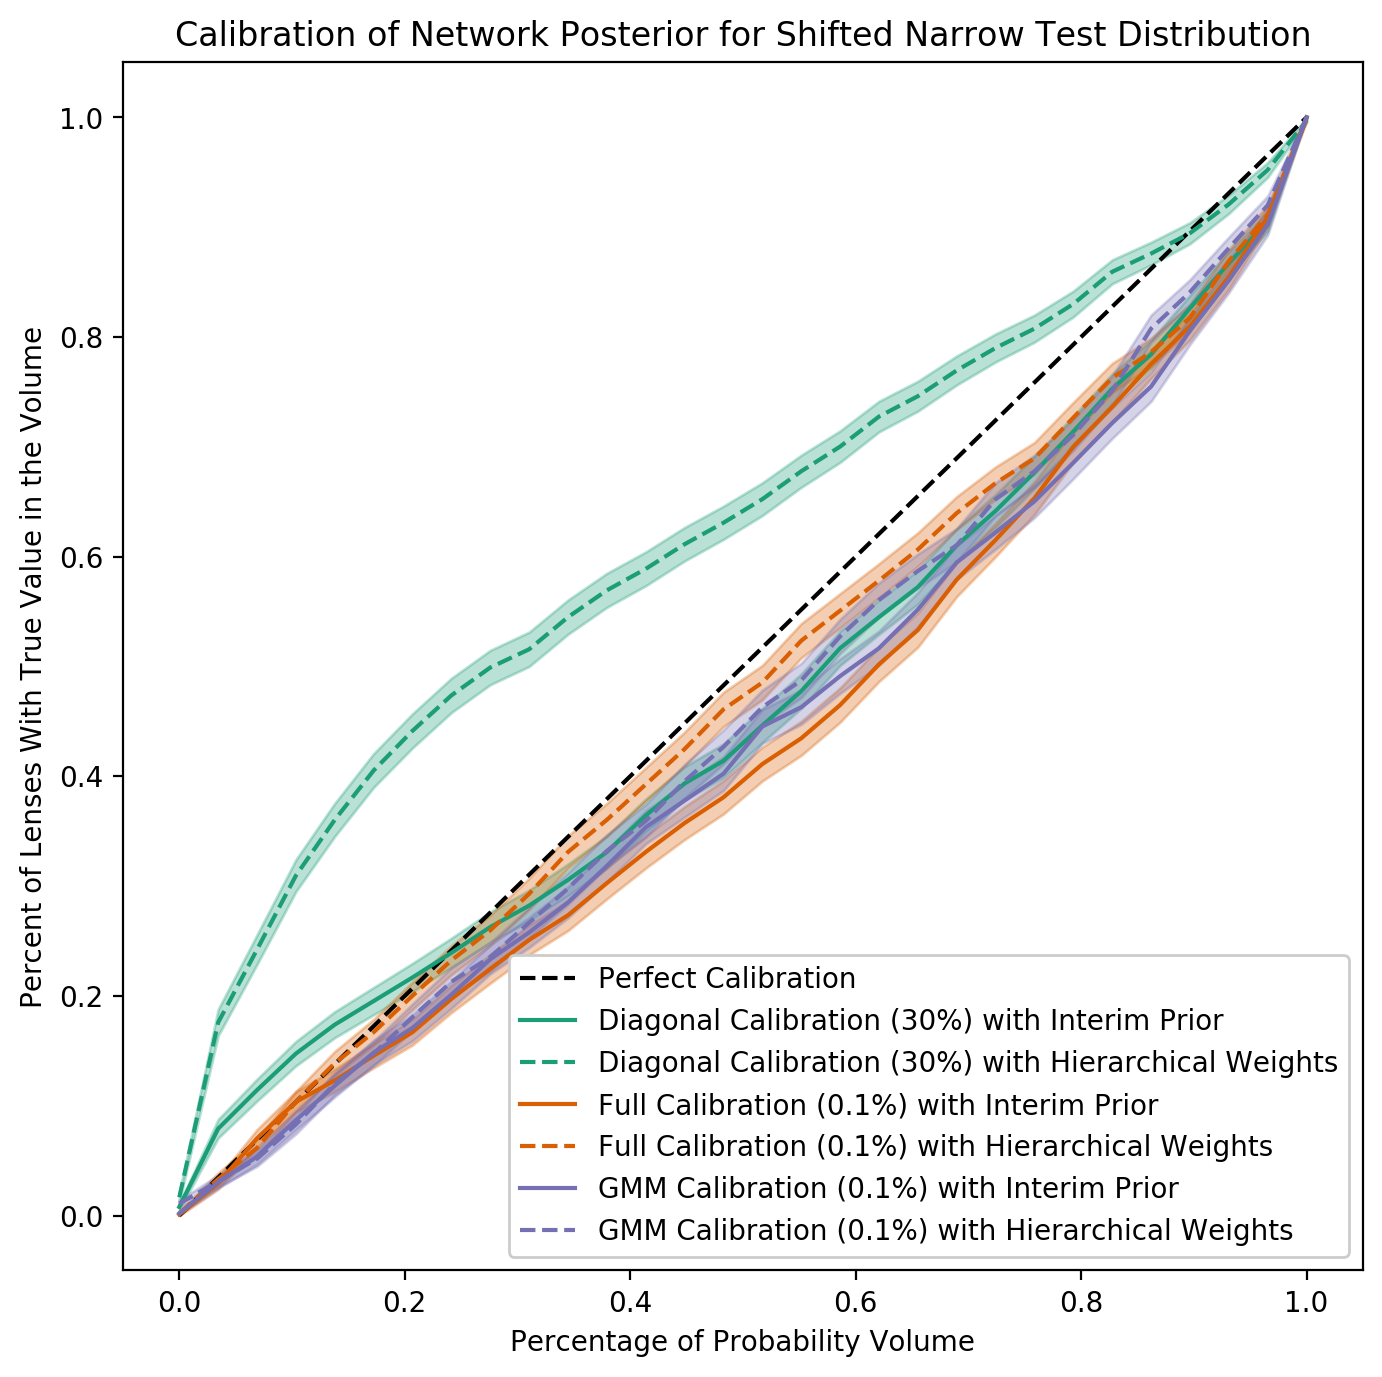

In [16]:
color_map = np.array(['#000000','#1b9e77','#d95f02','#7570b3','#e7298a'])
legend=[r'Perfect Calibration',r'Diagonal Calibration (30%) with Interim Prior',
        r'Diagonal Calibration (30%) with Hierarchical Weights',r'Full Calibration (0.1%) with Interim Prior',
        r'Full Calibration (0.1%) with Hierarchical Weights',r'GMM Calibration (0.1%) with Interim Prior',
        r'GMM Calibration (0.1%) with Hierarchical Weights']
ls_list =['-','--']
n_perc_points = 30
n_p_omega_samps = 100
fig = hier_infer_nn1.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,1,1]],legend=None,ls_list=ls_list)
fig = hier_infer_nn2.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,2,2]],legend=None,ls_list=ls_list,
                                                 figure=fig)
fig = hier_infer_nn3.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,3,3]],legend=None,ls_list=ls_list,
                                                 figure=fig)

plt.legend(legend,loc=0,framealpha=1.0)
plt.title('Calibration of Network Posterior for Shifted Narrow Test Distribution')
plt.xlabel('Percentage of Probability Volume')
plt.ylabel('Percent of Lenses With True Value in the Volume')
plt.savefig('figures/calibration_sn.pdf')
plt.show()

We can repeat the same comparison of all the distribution values

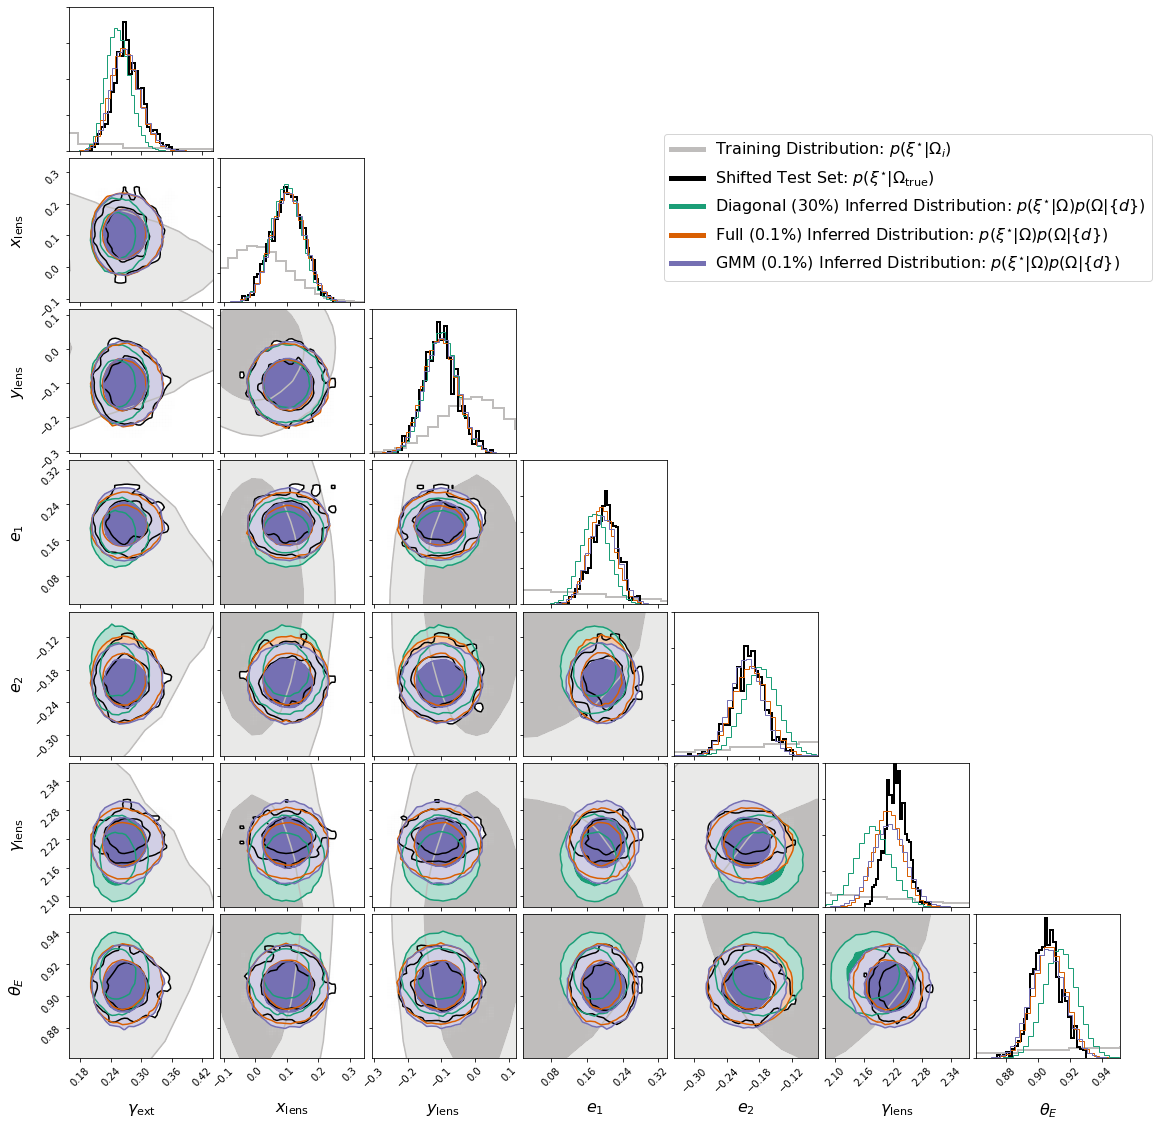

In [17]:
# Most of this code mirrors the code used to plot the distributions in the first panel. The only change is that now
# we're only plotting one test distribution and we're plotting the GMM inferred distribution
figure= None
color_map_distributions = ['#bfbdbc','#000000','#1b9e77','#d95f02','#7570b3']
plot_limits = None#[[0,0.2],[-0.3,0.3],[-0.3,0.3],[-0.3,0.3],[-0.3,0.3],[1.9,2.1],[0.9,1.1]]
hist_limit = [20,10,10,20,20,20,50]
# We need to smooth our test distribution because it has few samples. Note that no smoothing is applied to the 
# plotting of the inferred distribution.
smooth = 1.1
fontsize = 16
hist_kwargs = {'density':True,'color':color_map_distributions[0],'lw':2}
figure = corner.corner(train_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[0],levels=[0.68,0.95],
                       fill_contours=True,fig=figure,range=plot_limits,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map_distributions[1]
figure = corner.corner(sn_samps,labels=final_params_print_names,bins=30,show_titles=False, plot_datapoints=False,
                       label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[1],levels=[0.68,0.95],
                       fill_contours=False,fig=figure,range=plot_limits,smooth=smooth,hist_kwargs=hist_kwargs)
hier_infer_nn1.plot_parameter_distribtuion(burnin,lens_params,n_p_omega_samps=100,samps_per_omega=1000,figure=figure,
                                          color=color_map_distributions[2],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names)
hier_infer_nn2.plot_parameter_distribtuion(burnin,lens_params,n_p_omega_samps=100,samps_per_omega=1000,figure=figure,
                                          color=color_map_distributions[3],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names)
hier_infer_nn3.plot_parameter_distribtuion(burnin,lens_params,n_p_omega_samps=100,samps_per_omega=1000,figure=figure,
                                          color=color_map_distributions[4],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names)
handles = [Line2D([0], [0], color=color_map_distributions[0], lw=5),
           Line2D([0], [0], color=color_map_distributions[1], lw=5),
           Line2D([0], [0], color=color_map_distributions[2], lw=5),
           Line2D([0], [0], color=color_map_distributions[3], lw=5),
           Line2D([0], [0], color=color_map_distributions[4], lw=5)]
figure.legend(handles,[r'Training Distribution: $p(\xi^{\star}|\Omega_i)$', 
                       r'Shifted Test Set: $p(\xi^{\star}|\Omega_\mathrm{true})$',
                       r'Diagonal (30%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $',
                       r'Full (0.1%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $',
                       r'GMM (0.1%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $'],
                       loc=(0.575,0.75),fontsize=fontsize)

axes = np.array(figure.axes).reshape((len(lens_params),len(lens_params)))
for i in range(len(lens_params)):
    axes[i,i].set_ylim(0,hist_limit[i])
    
plt.savefig('figures/sn_distribution_comp.pdf')
plt.show()

## Compare performance of all three model types on the empirical test distribution

Once again, we need to load all of the bnns and their samples from the hierarchical inference

In [18]:
# Diagonal model 30% dropout chains on shifted test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/empirical_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/empirical.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_emp'
train_to_test_param_map = dict(orig_params=['lens_mass_e1','lens_mass_e2'],transform_func=ellipticity2phi_q,
                               new_params=['lens_mass_phi','lens_mass_q'])
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{\log(\theta_E)}$',r'$\mu_{\log(q_\mathrm{lens})}$',
                         r'$\mu_{\log(\gamma_\mathrm{lens})}$',
                         r'$\Sigma_{\log(\theta_E),\log(\theta_E)}$',
                         r'$\Sigma_{\log(\theta_E),\log(q_\mathrm{lens})}$',
                         r'$\Sigma_{\log(q_\mathrm{lens}),\log(q_\mathrm{lens})}$',
                         r'$\Sigma_{\log(\theta_E),\log(\gamma_\mathrm{lens})}$',
                         r'$\Sigma_{\log(q_\mathrm{lens}),\log(\gamma_\mathrm{lens})}$',
                         r'$\Sigma_{\log(\gamma_\mathrm{lens})},\log(\gamma_\mathrm{lens})}$']
lens_params_non_cov = ['external_shear_gamma_ext','lens_mass_center_x','lens_mass_center_y']
final_params_print_names_cov = [r'$\gamma_\mathrm{ext}$',r'$x_\mathrm{lens}$',r'$y_\mathrm{lens}$',
                                r'$\theta_E$',r'$q_\mathrm{lens}$',r'$\gamma_\mathrm{lens}$']
# We used more walkers for the empirical distributions
n_walkers = 200

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn1_hr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn1 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                             train_to_test_param_map=train_to_test_param_map)
save_path_samples_nn1_hr = root_path + 'hierarchical_results/emp_nn1_hr_samps/'
hier_infer_nn1.gen_samples(num_samples,save_path_samples_nn1_hr)
save_path_chains_nn1_hr = root_path + 'hierarchical_results/emp_nn1_hr.h5'
hier_infer_nn1.initialize_sampler(n_walkers,save_path_chains_nn1_hr)

# Repeat this process for our remaining two distributions
# Full Model 0.1% Dropout
config_path = root_path + 'configs/nn2_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn2 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                                train_to_test_param_map=train_to_test_param_map)
save_path_samples_nn2_slr = root_path + 'hierarchical_results/emp_nn2_slr_samps/'
hier_infer_nn2.gen_samples(num_samples,save_path_samples_nn2_slr)
save_path_chains_nn2_slr = root_path + 'hierarchical_results/emp_nn2_slr.h5'
hier_infer_nn2.initialize_sampler(n_walkers,save_path_chains_nn2_slr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path,
                                                              train_to_test_param_map=train_to_test_param_map)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/emp_nn3_slr_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/emp_nn3_slr.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn1_hr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/tf_record_emp
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn1_hr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn1_hr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn1_hr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn2_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/empirical/tf_record_emp
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/emp_nn2_slr_samps/
Loading samples from /Users/sebwagner/D

As above, commented out but worth running once to make sure what you see is reasonable

In [19]:
burnin = 4000
# hier_infer_nn1.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn1.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn2.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn2.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

We'll focus on the posterior plots for the covariance matrix parameters.

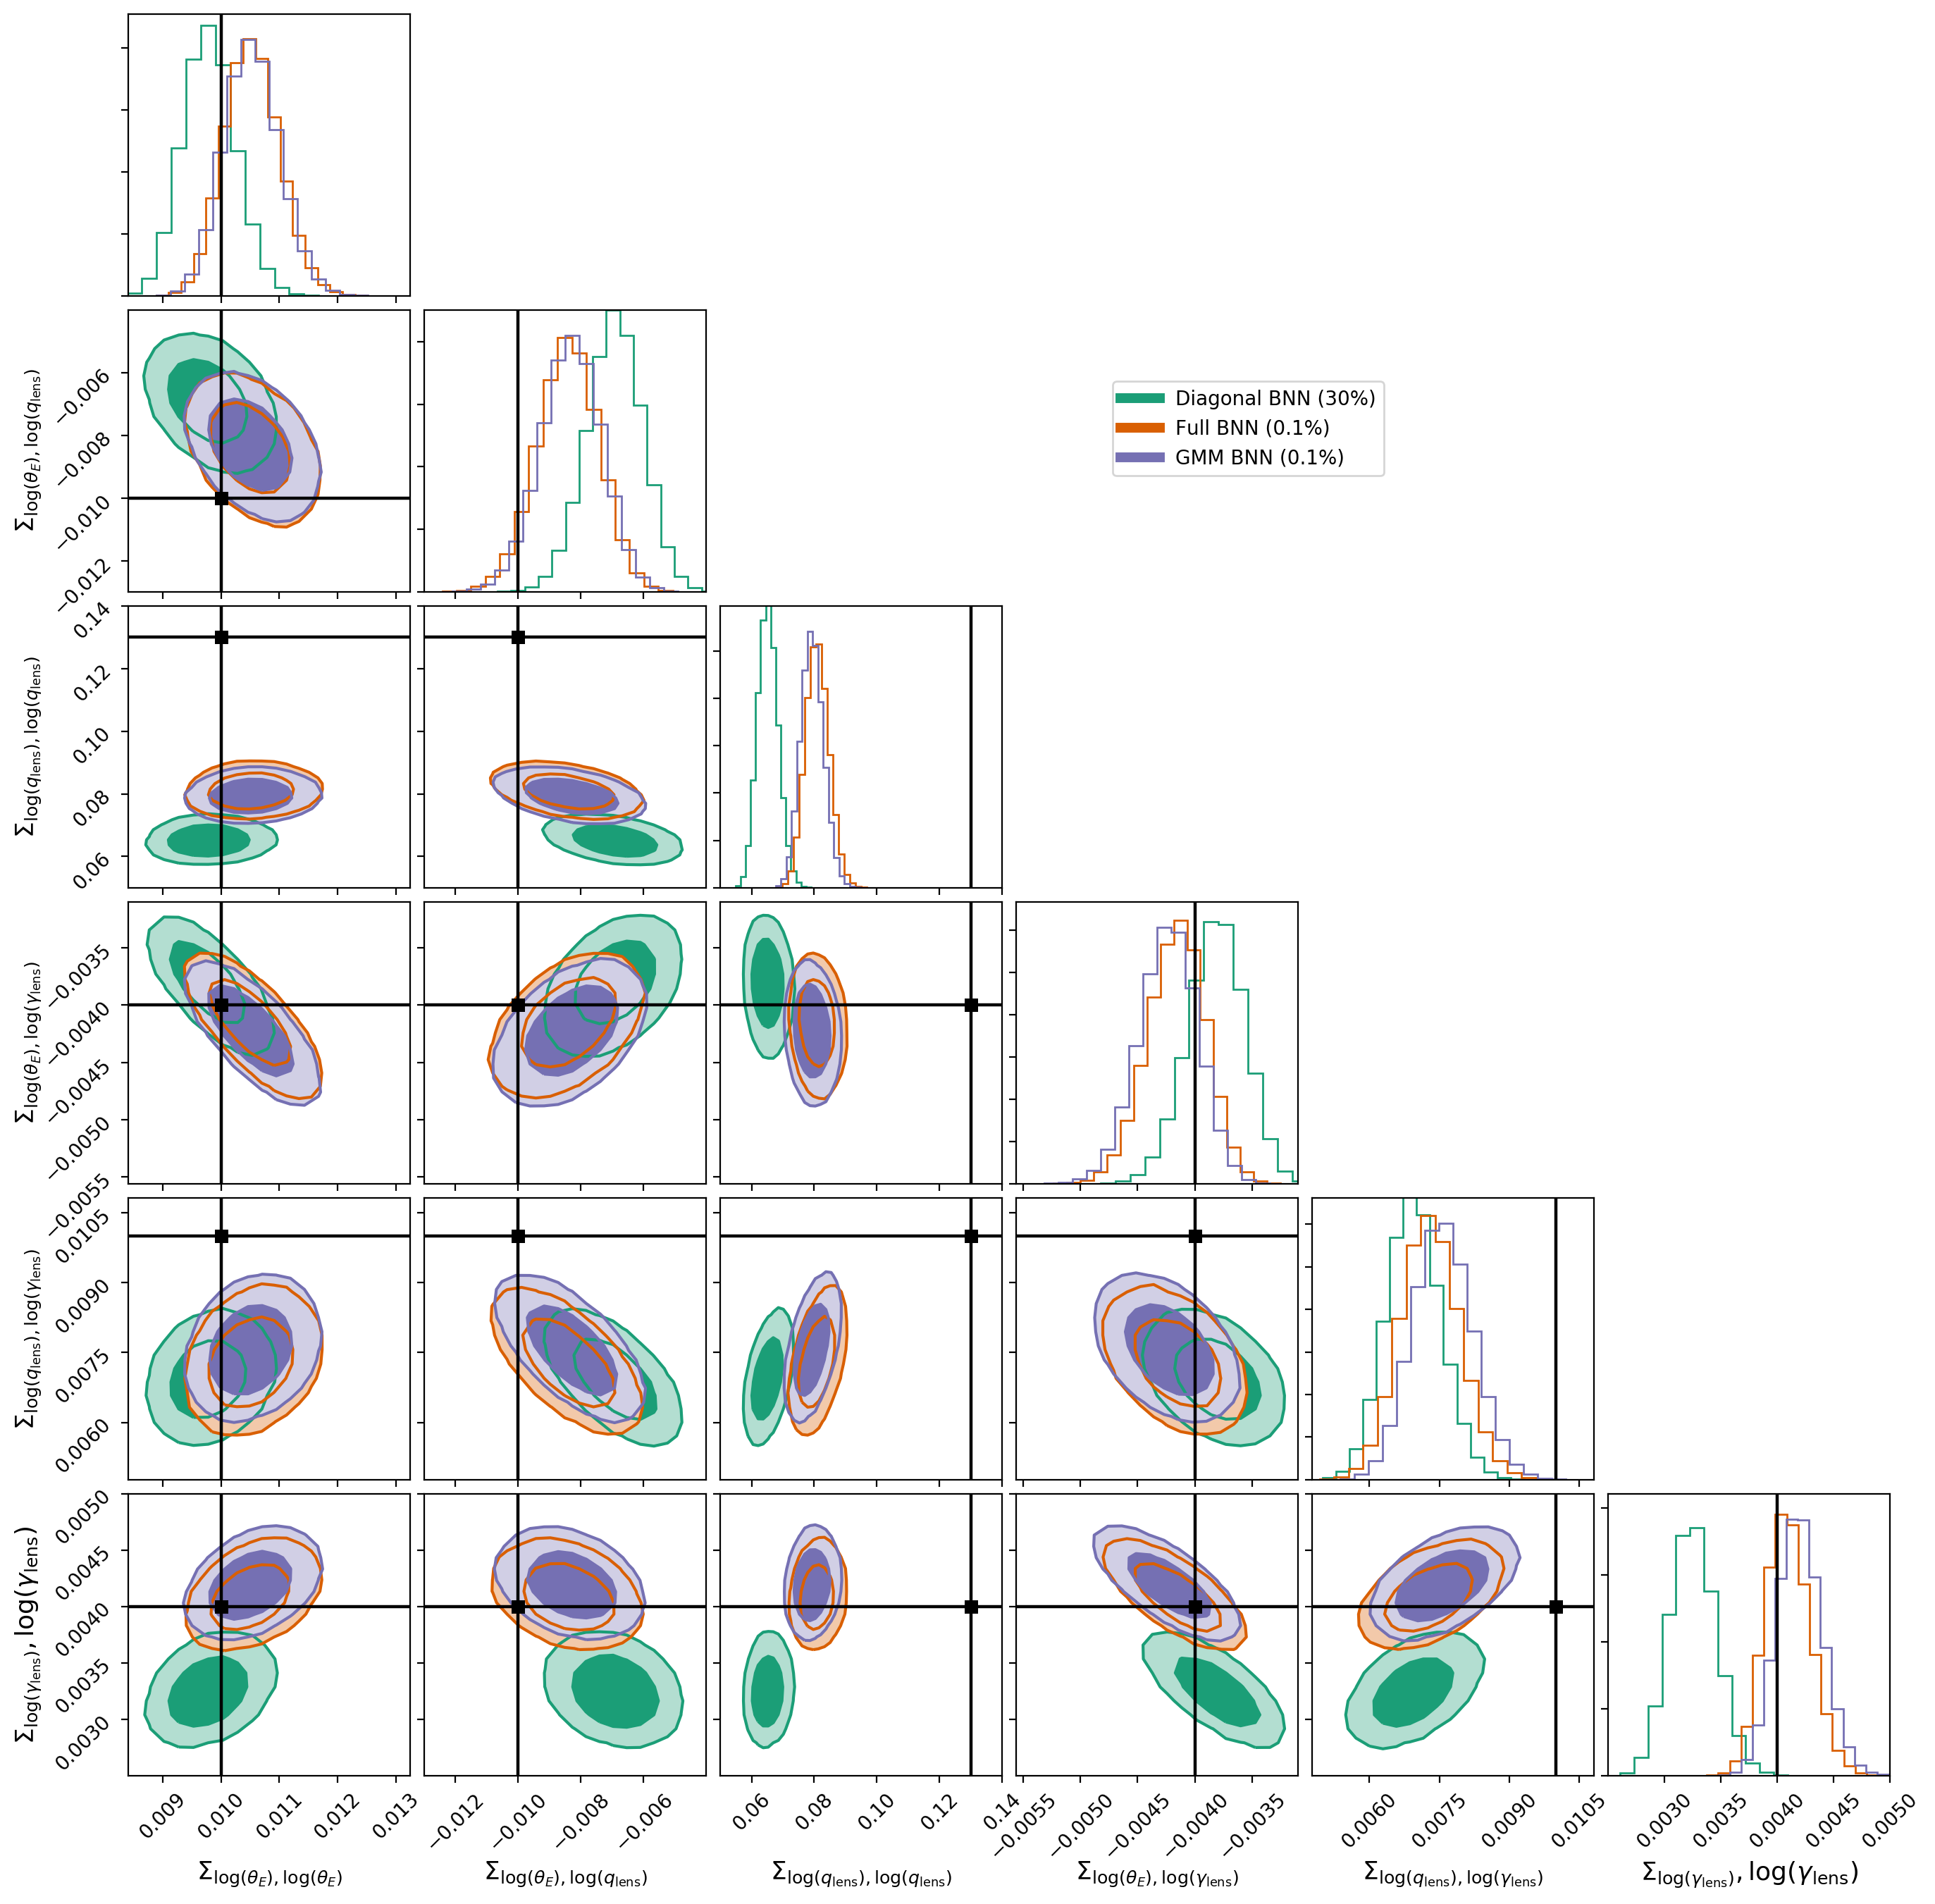

In [40]:
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figures[0].legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figures[1].legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
figures[1]

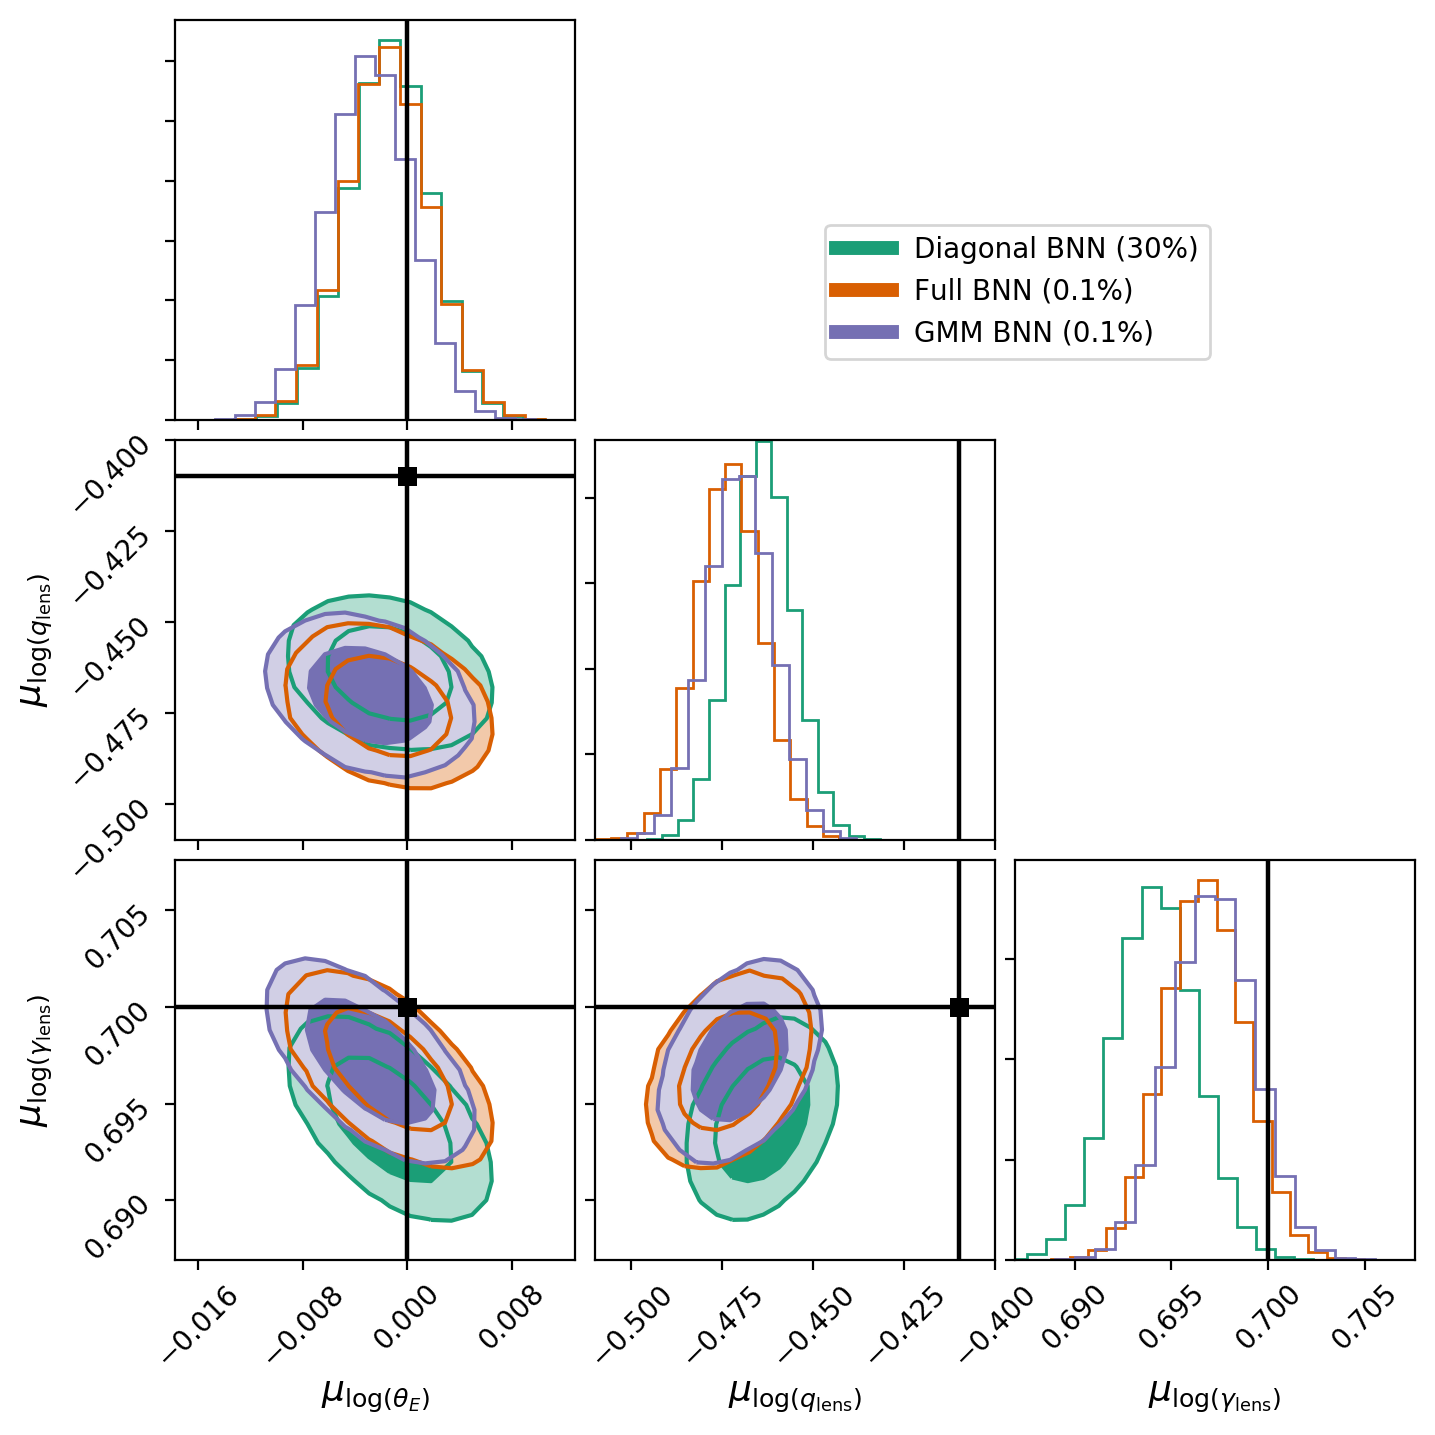

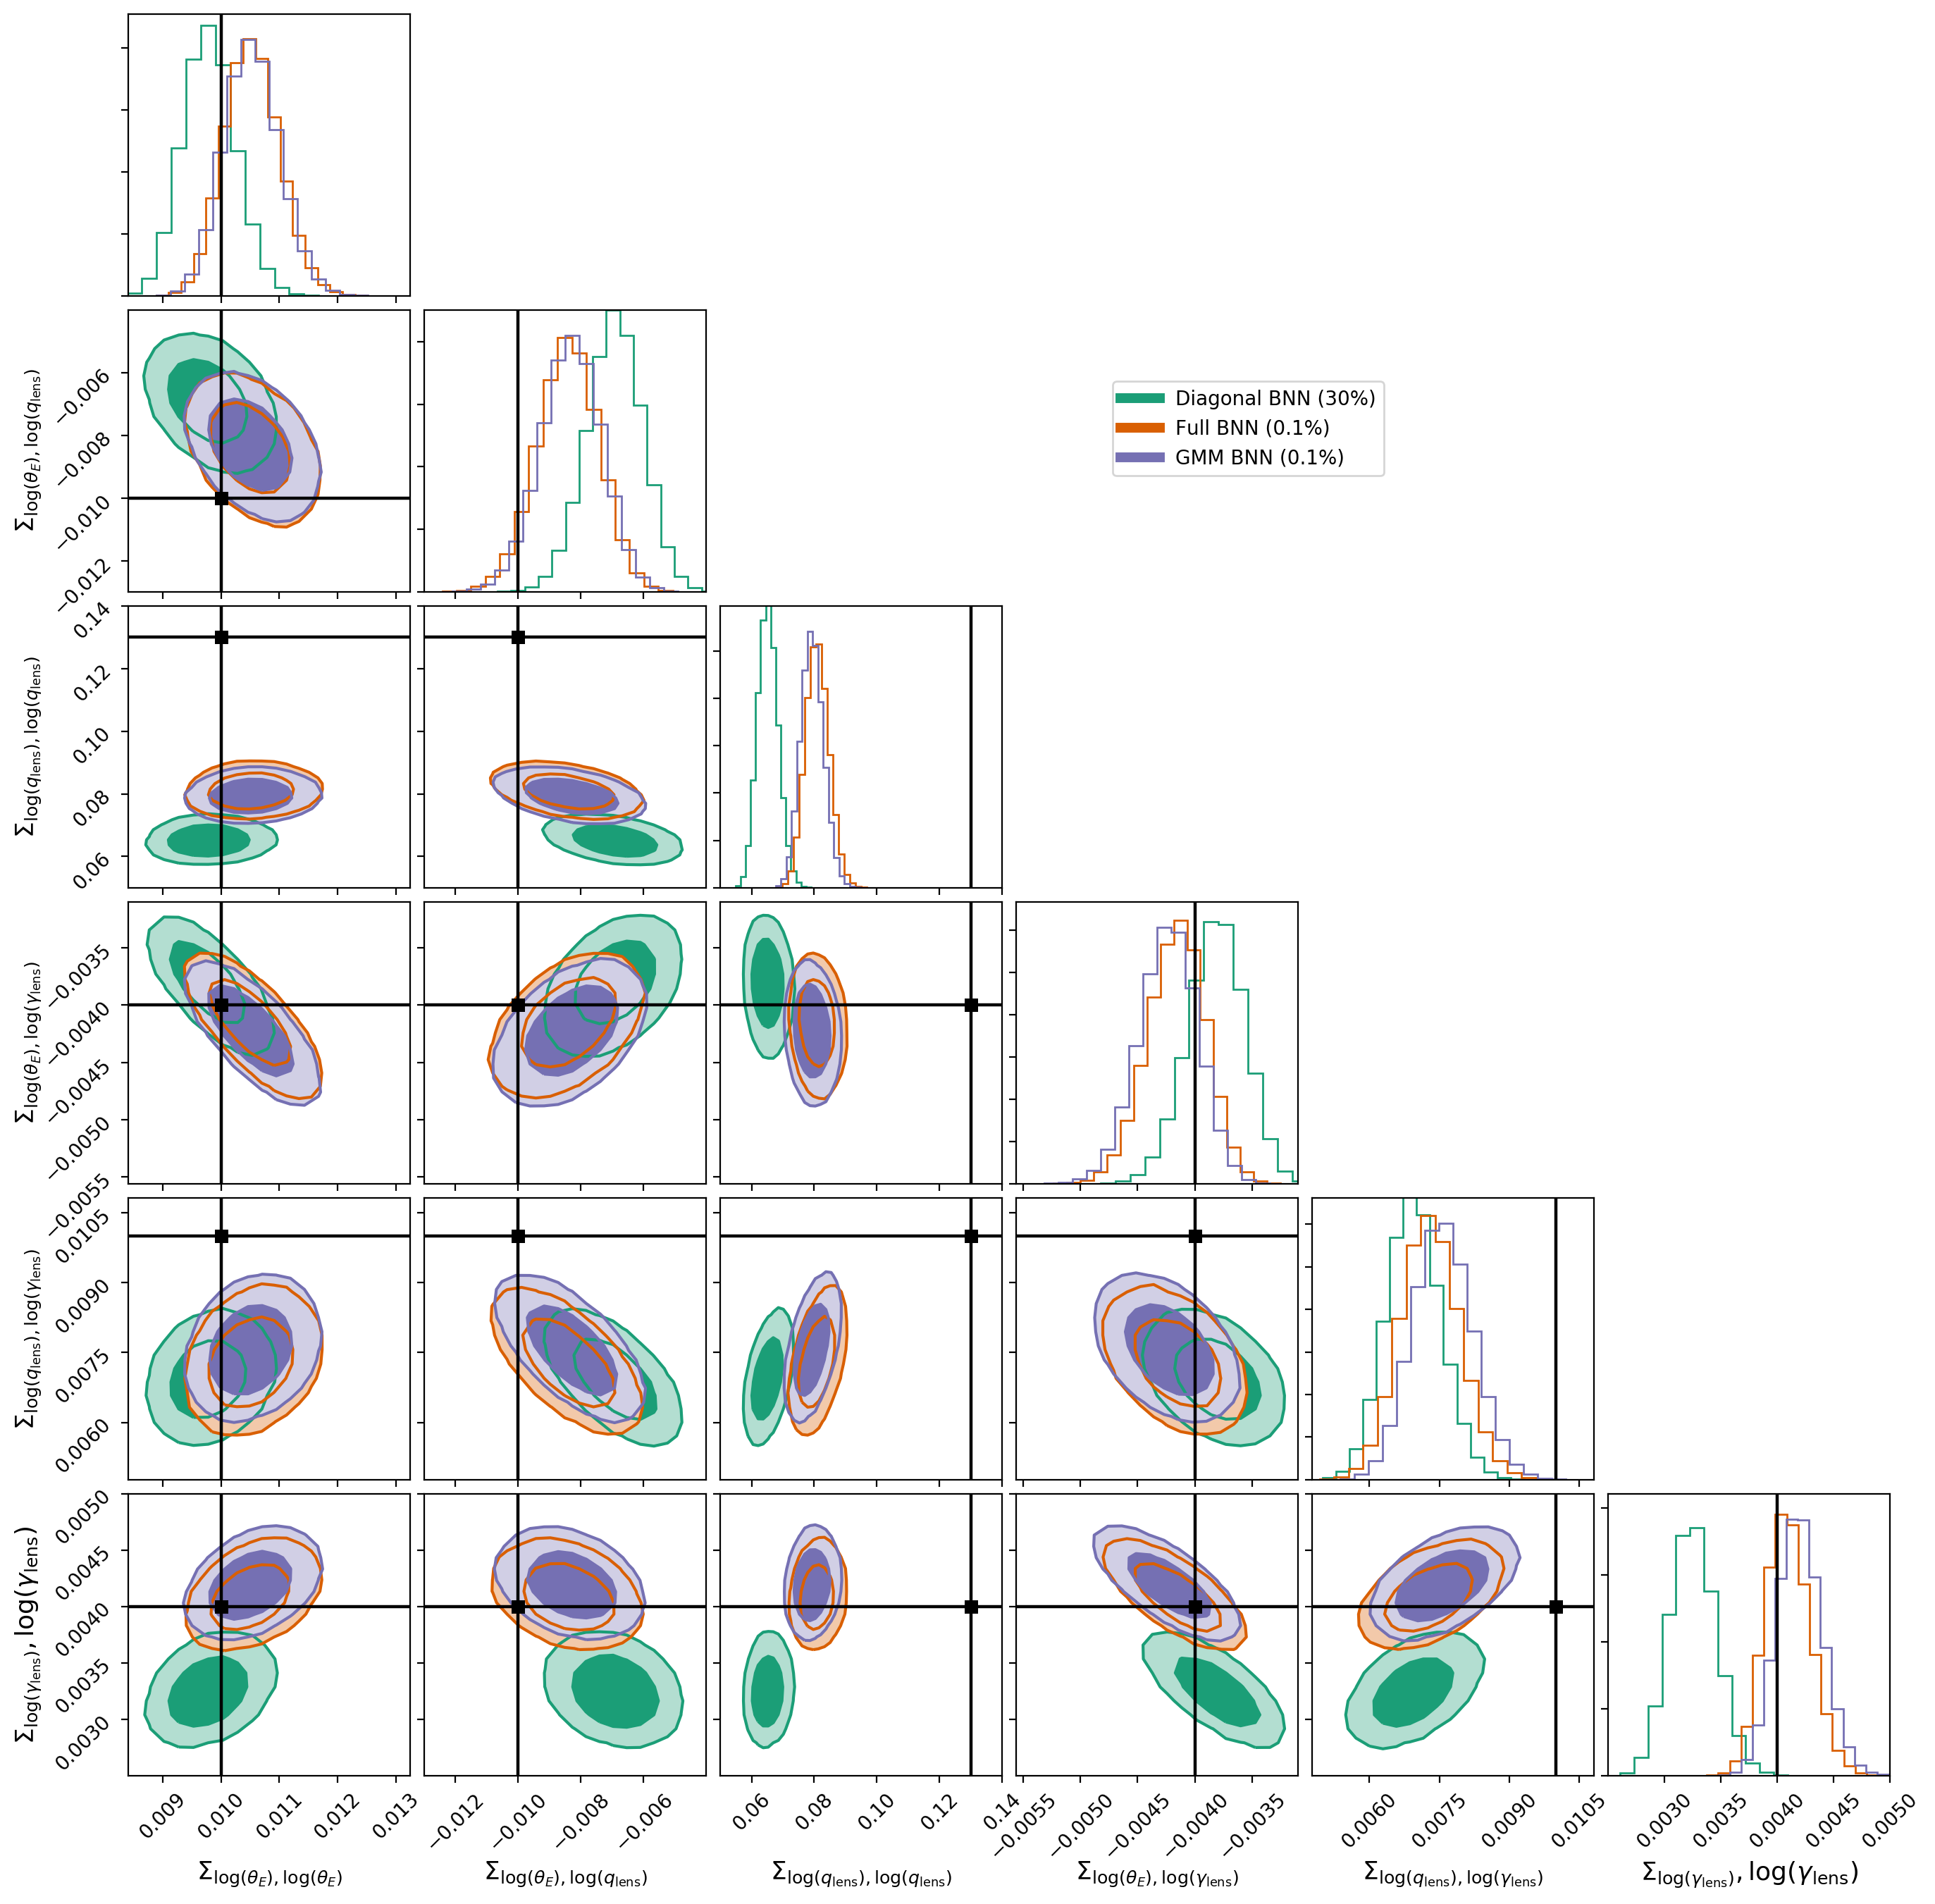

In [42]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
plot_range = None
figures = None
figures = hier_infer_nn1.plot_cov_corner(burnin,hyperparam_plot_names,color='#1b9e77',figures = figures)
figures = hier_infer_nn2.plot_cov_corner(burnin,hyperparam_plot_names,color='#d95f02',figures = figures)
figures = hier_infer_nn3.plot_cov_corner(burnin,hyperparam_plot_names,color='#7570b3',figures = figures)

# Modify the axis limits manually to get the Diagonal posterior
figures[0].axes[3].set_ylim([-0.51,-0.40])
figures[0].axes[4].set_xlim([-0.51,-0.40])
figures[0].axes[3].set_ylim([-0.51,-0.40])
figures[0].axes[7].set_xlim([-0.51,-0.40])
figures[1].axes[12].set_ylim([0.05,0.14])
figures[1].axes[13].set_ylim([0.05,0.14])
figures[1].axes[14].set_xlim([0.05,0.14])
figures[1].axes[20].set_xlim([0.05,0.14])
figures[1].axes[26].set_xlim([0.05,0.14])
figures[1].axes[32].set_xlim([0.05,0.14])
figures[1].axes[30].set_ylim([0.0025,0.005])
figures[1].axes[31].set_ylim([0.0025,0.005])
figures[1].axes[32].set_ylim([0.0025,0.005])
figures[1].axes[33].set_ylim([0.0025,0.005])
figures[1].axes[34].set_ylim([0.0025,0.005])
figures[1].axes[35].set_xlim([0.0025,0.005])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figures[0].legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
figures[1].legend(handles,[r'Diagonal BNN (30%)', r'Full BNN (0.1%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))


figures[0].savefig('figures/emp_cov_mean_2d_hyps.pdf')
figures[1].savefig('figures/emp_cov_sigma_2d_hyps.pdf')
plt.show(figures[0])
plt.show(figures[1])

We can check the calibration of our networks. Here, we don't expect to start with as substantial of a bias as the shifted narrow distribution. We expect something closer to the center narrow distribution and that's what we get.

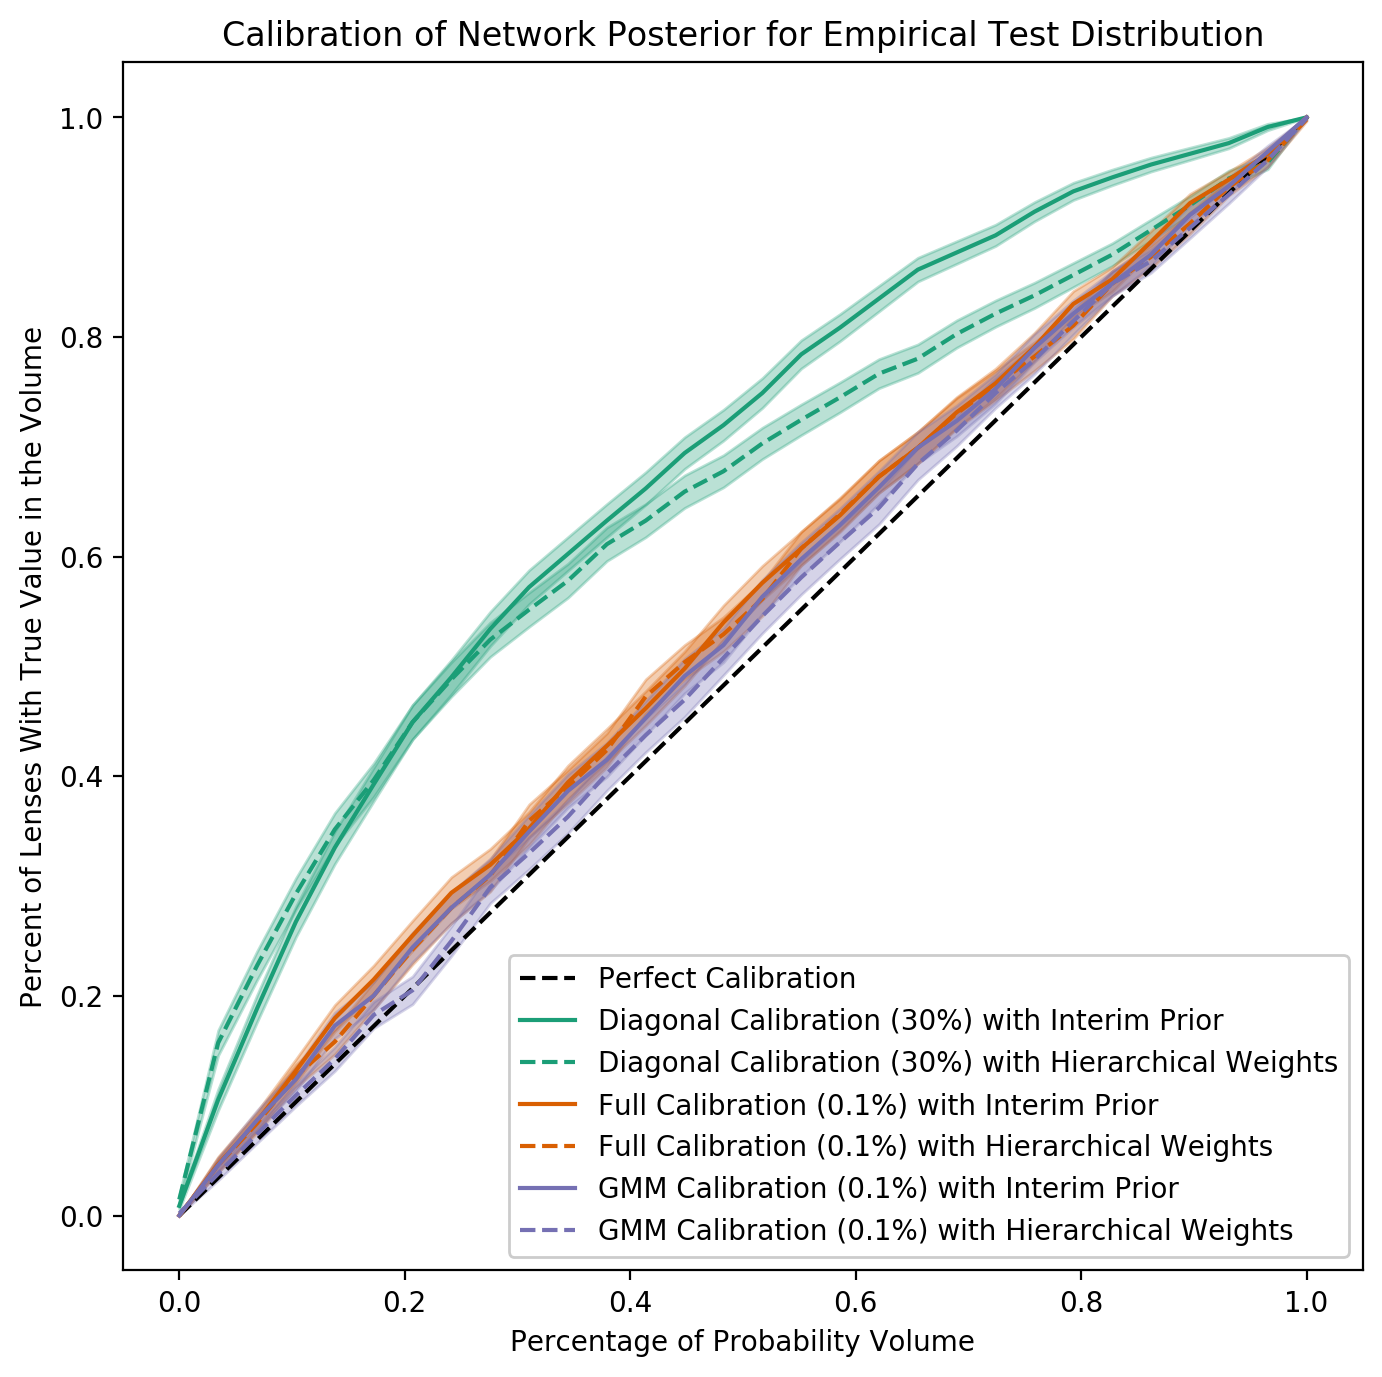

In [43]:
color_map = np.array(['#000000','#1b9e77','#d95f02','#7570b3','#e7298a'])
legend=[r'Perfect Calibration',r'Diagonal Calibration (30%) with Interim Prior',
        r'Diagonal Calibration (30%) with Hierarchical Weights',r'Full Calibration (0.1%) with Interim Prior',
        r'Full Calibration (0.1%) with Hierarchical Weights',r'GMM Calibration (0.1%) with Interim Prior',
        r'GMM Calibration (0.1%) with Hierarchical Weights']
ls_list =['-','--']
n_perc_points = 30
n_p_omega_samps = 100
fig = hier_infer_nn1.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,1,1]],legend=None,ls_list=ls_list)
fig = hier_infer_nn2.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,2,2]],legend=None,ls_list=ls_list,
                                                 figure=fig)
fig = hier_infer_nn3.plot_reweighted_calibration(burnin,n_perc_points,n_p_omega_samps=n_p_omega_samps,
                                                 color_map=color_map[[0,3,3]],legend=None,ls_list=ls_list,
                                                 figure=fig)

plt.legend(legend,loc=0,framealpha=1.0)
plt.title('Calibration of Network Posterior for Empirical Test Distribution')
plt.xlabel('Percentage of Probability Volume')
plt.ylabel('Percent of Lenses With True Value in the Volume')
plt.savefig('figures/calibration_em.pdf')
plt.show()

We can compare the distribution here as before. The one tricky part is that we need to modify the trianing samps
such that we are sampling q instead of e1 and e2.

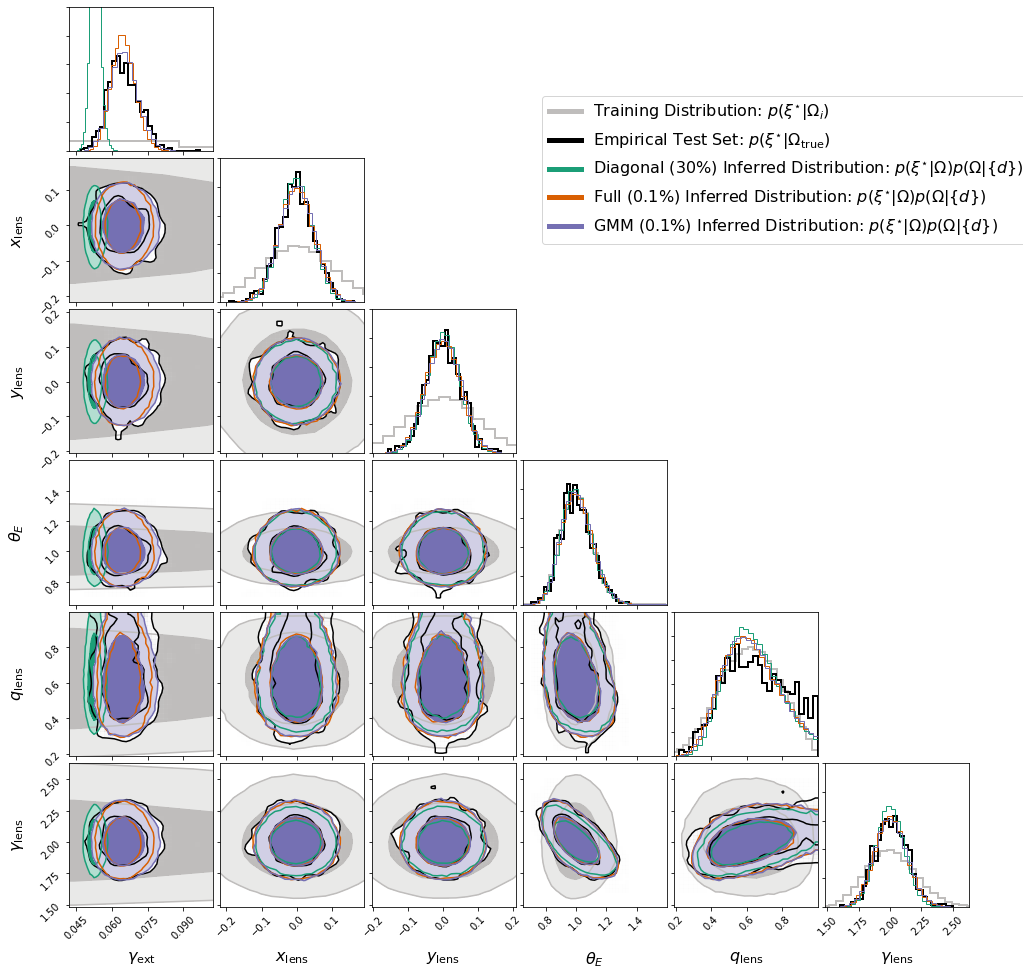

In [44]:
figure= None
color_map_distributions = ['#bfbdbc','#000000','#1b9e77','#d95f02','#7570b3']
plot_limits = None#[[0,0.2],[-0.3,0.3],[-0.3,0.3],[-0.3,0.3],[-0.3,0.3],[1.9,2.1],[0.9,1.1]]
hist_limit = [100,10,10,5,3,5]

# Generate training and empirical samples where we have q instead of e1,e2
train_samps_cov = np.copy(train_samps)
te1,te2 = train_samps_cov[:,[3,4]].T
emp_samps_cov = np.copy(emp_samps)
ee1,ee2 = emp_samps_cov[:,[3,4]].T
# Convert to q
_, tq = ellipticity2phi_q(te1,te2)
_, eq = ellipticity2phi_q(ee1,ee2)
# Insert back into the array and do some reordering
train_samps_cov[:,3] = tq
train_samps_cov = np.delete(train_samps_cov,4,axis=1)
train_samps_cov[:,[3,4,5]] = train_samps_cov[:,[5,3,4]]
emp_samps_cov[:,3] = eq
emp_samps_cov = np.delete(emp_samps_cov,4,axis=1)
emp_samps_cov[:,[3,4,5]] = emp_samps_cov[:,[5,3,4]]

# We need to smooth our test distribution because it has few samples. Note that no smoothing is applied to the 
# plotting of the inferred distribution.
smooth = 1.1
fontsize = 16
hist_kwargs = {'density':True,'color':color_map_distributions[0],'lw':2}

figure = corner.corner(train_samps_cov,labels=final_params_print_names_cov,bins=30,show_titles=False, 
                       plot_datapoints=False,label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[0],
                       levels=[0.68,0.95],fill_contours=True,fig=figure,range=plot_limits,hist_kwargs=hist_kwargs)
hist_kwargs['color']=color_map_distributions[1]
figure = corner.corner(emp_samps_cov,labels=final_params_print_names_cov,bins=30,show_titles=False, 
                       plot_datapoints=False, label_kwargs=dict(fontsize=fontsize),color=color_map_distributions[1],
                       levels=[0.68,0.95],fill_contours=False,fig=figure,range=plot_limits,smooth=smooth,
                       hist_kwargs=hist_kwargs)
hier_infer_nn1.plot_parameter_distribtuion(burnin,lens_params_non_cov,n_p_omega_samps=100,samps_per_omega=1000,
                                           figure=figure,color=color_map_distributions[2],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names_cov,
                                           cov_params=True)
hier_infer_nn2.plot_parameter_distribtuion(burnin,lens_params_non_cov,n_p_omega_samps=100,samps_per_omega=1000,
                                           figure=figure,color=color_map_distributions[3],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names_cov,
                                           cov_params=True)
hier_infer_nn3.plot_parameter_distribtuion(burnin,lens_params_non_cov,n_p_omega_samps=100,samps_per_omega=1000,
                                           figure=figure,color=color_map_distributions[4],plot_limits=plot_limits,
                                           fontsize=fontsize,param_print_names=final_params_print_names_cov,
                                           cov_params=True)
handles = [Line2D([0], [0], color=color_map_distributions[0], lw=5),
           Line2D([0], [0], color=color_map_distributions[1], lw=5),
           Line2D([0], [0], color=color_map_distributions[2], lw=5),
           Line2D([0], [0], color=color_map_distributions[3], lw=5),
           Line2D([0], [0], color=color_map_distributions[4], lw=5)]
figure.legend(handles,[r'Training Distribution: $p(\xi^{\star}|\Omega_i)$', 
                       r'Empirical Test Set: $p(\xi^{\star}|\Omega_\mathrm{true})$',
                       r'Diagonal (30%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $',
                       r'Full (0.1%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $',
                       r'GMM (0.1%) Inferred Distribution: $p(\xi^{\star}|\Omega)p(\Omega|\{d\}) $'],
                       loc=(0.53,0.75),fontsize=fontsize)

axes = np.array(figure.axes).reshape((len(final_params_print_names_cov),len(final_params_print_names_cov)))
for i in range(len(final_params_print_names_cov)):
    axes[i,i].set_ylim(0,hist_limit[i])
    
plt.savefig('figures/emp_distribution_comp.pdf')
plt.show()

## Compare performance of GMM model, varying dropout rate, on centered narrow

For this comparison, we are mainly only intereted in looking at the 2d posteriors on the population parameters.

In [53]:
# Diagonal model 30% dropout chains on shifted test distribution
# Specify the paths for our distribution configs, the test set, and the location on the saved BNN samples and chains
interim_baobab_omega_path = root_path + 'configs/baobab_configs/train_diagonal.py'
target_ovejero_omega_path = root_path + 'configs/baobab_configs/cent_narrow_cfg_prior.py'
target_baobab_omega_path = root_path + 'configs/baobab_configs/cent_narrow.py'
test_dataset_path = '/Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/'
test_dataset_tf_record_path = test_dataset_path + 'tf_record_cn'
n_walkers = 50
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\log (\gamma_\mathrm{lens})}$',r'$\sigma_{\log (\gamma_\mathrm{lens})}$',
                         r'$\mu_{\log (\theta_E)}$',r'$\sigma_{\log (\theta_E)}$']

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3_slr = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3_slr.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3_slr.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

config_path = root_path + 'configs/nn3_lr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3_lr = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_lr = root_path + 'hierarchical_results/cn_nn3_lr_samps/'
hier_infer_nn3_lr.gen_samples(num_samples,save_path_samples_nn3_lr)
save_path_chains_nn3_lr = root_path + 'hierarchical_results/cn_nn3_lr.h5'
hier_infer_nn3_lr.initialize_sampler(n_walkers,save_path_chains_nn3_lr)

# GMM Model 0.1% Dropout
config_path = root_path + 'configs/nn3.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)
hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3 = root_path + 'hierarchical_results/cn_nn3_samps/'
hier_infer_nn3.gen_samples(num_samples,save_path_samples_nn3)
save_path_chains_nn3 = root_path + 'hierarchical_results/cn_nn3.h5'
hier_infer_nn3.initialize_sampler(n_walkers,save_path_chains_nn3)

Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr.h5
Is model built: True
Loaded weights /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_lr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_lr_samps/
Loading samples from /Users/sebwagner/D

In [54]:
burnin = 8000
# hier_infer_nn3_slr.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3_lr.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_lr.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

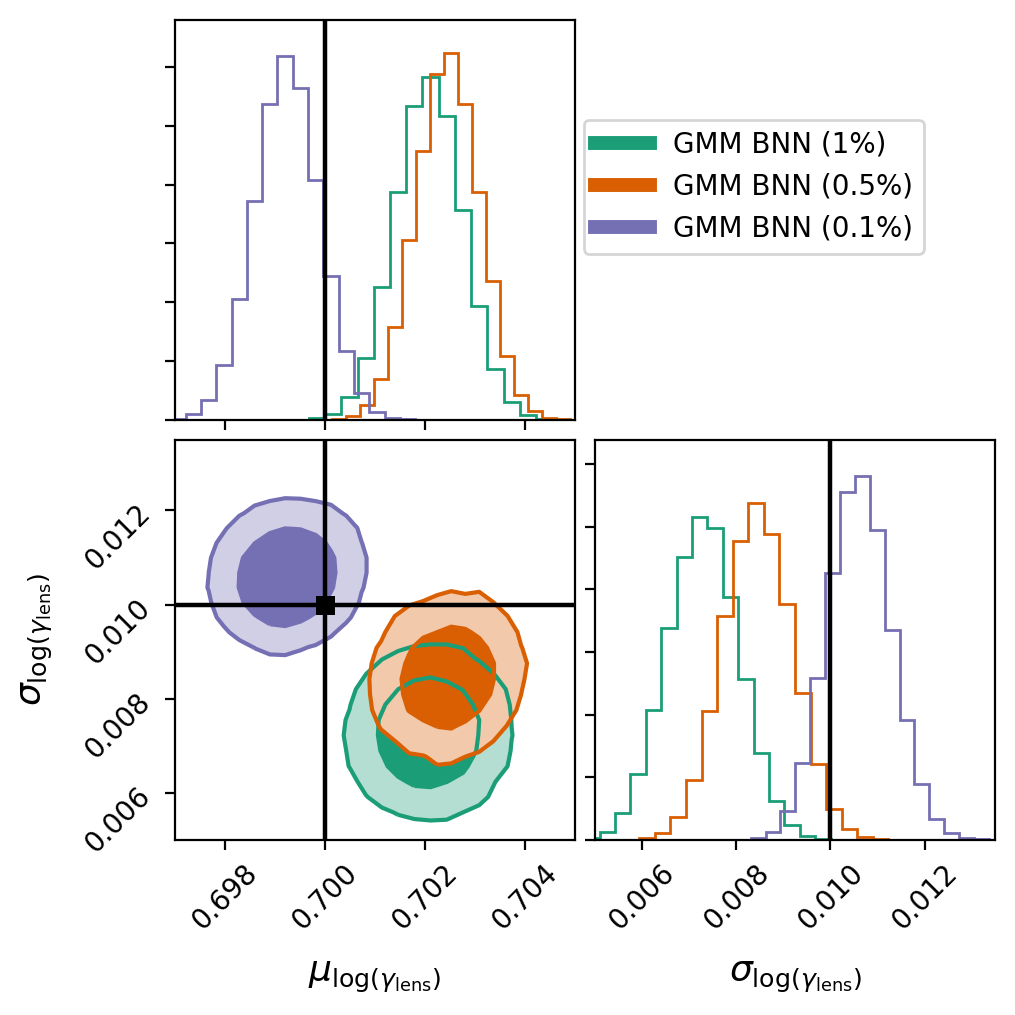

In [55]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = None#[[0.77,0.802],[0.009,0.02]]
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn3_lr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Change the axis to include all the posteriors
figure.axes[0].set_xlim([0.697,0.705])
figure.axes[2].set_xlim([0.697,0.705])
figure.axes[2].set_ylim([0.005,0.0135])
figure.axes[3].set_xlim([0.005,0.0135])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN (1%)', r'GMM BNN (0.5%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_lens_2d_hyps_r.pdf')
plt.show(figure)

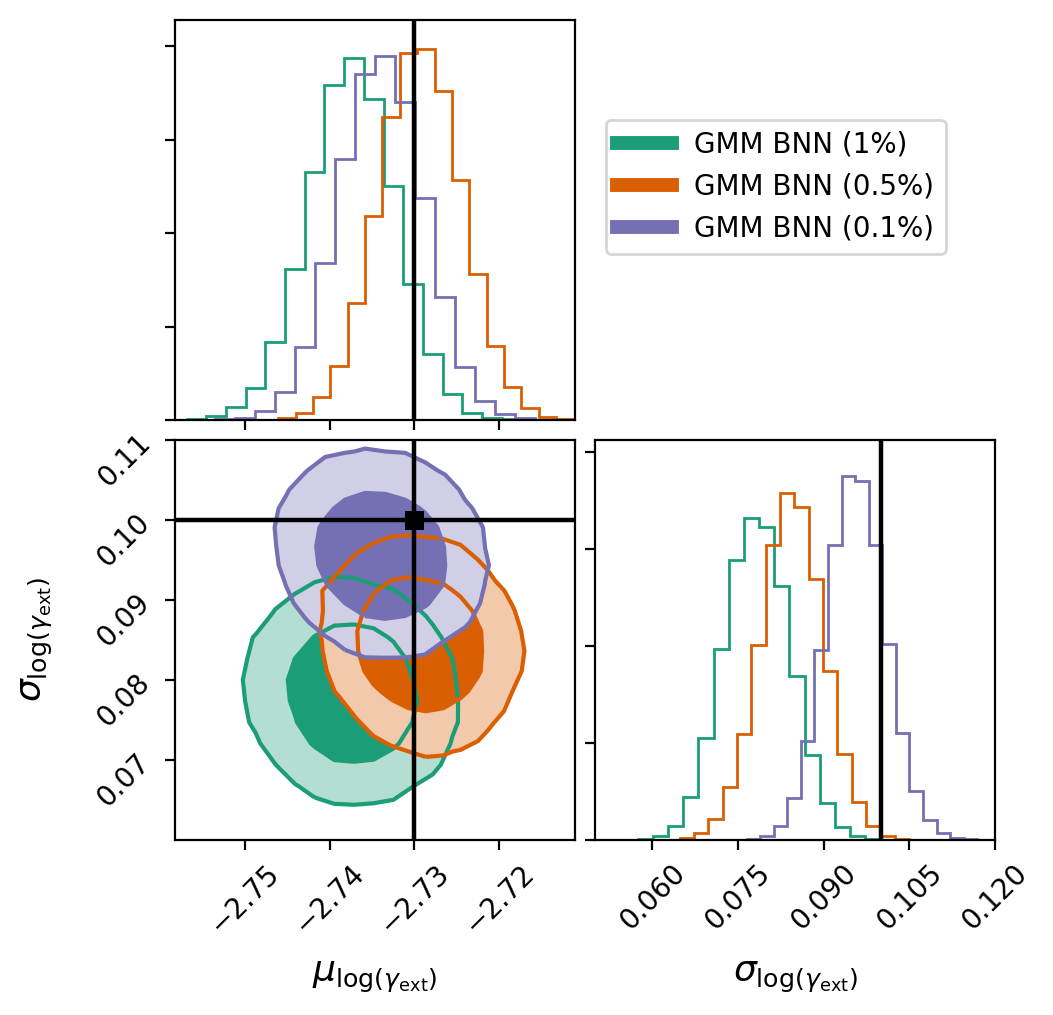

In [56]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
plot_range = None#[[0.77,0.802],[0.009,0.02]]
figure = hier_infer_nn3.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn3_lr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Change the axis to include all the posteriors
figure.axes[2].set_ylim([0.06,0.11])
figure.axes[3].set_xlim([0.05,0.12])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN (1%)', r'GMM BNN (0.5%)',r'GMM BNN (0.1%)'],
              loc=(0.575,0.75))
plt.savefig('figures/cn_gamma_ext_2d_hyps_r.pdf')
plt.show(figure)

## Compare performance of GMM model, varying number of lenses, on centered narrow

As before, we're mainly intereted in plotting the 2d posteriors here.

In [49]:
# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need only open up our config and pass the paths we set above.
config_path = root_path + 'configs/nn3_slr.json'
cfg = model_trainer.load_config(config_path)
recursive_str_checker(cfg)

hier_infer_nn3 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
save_path_samples_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr_samps/'
hier_infer_nn3_slr.gen_samples(num_samples,save_path_samples_nn3_slr)
save_path_chains_nn3_slr = root_path + 'hierarchical_results/cn_nn3_slr.h5'
hier_infer_nn3_slr.initialize_sampler(n_walkers,save_path_chains_nn3_slr)

# Now 256 lenses
hier_infer_nn3_slr_256 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
num_lenses = 256
hier_infer_nn3_slr_256.gen_samples(num_samples,save_path_samples_nn3_slr,num_lenses)
save_path_chains_nn3_slr_256 = root_path + 'hierarchical_results/cn_nn3_slr_256.h5'
hier_infer_nn3_slr_256.initialize_sampler(n_walkers,save_path_chains_nn3_slr_256)

# GMM Model 0.1% Dropout
hier_infer_nn3_slr_64 = hierarchical_inference.HierarchicalClass(cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                             test_dataset_path,test_dataset_tf_record_path,
                                                             target_baobab_omega_path=target_baobab_omega_path)
num_lenses = 64
hier_infer_nn3_slr_64.gen_samples(num_samples,save_path_samples_nn3_slr,num_lenses)
save_path_chains_nn3_slr_64 = root_path + 'hierarchical_results/cn_nn3_slr_64.h5'
hier_infer_nn3_slr_64.initialize_sampler(n_walkers,save_path_chains_nn3_slr_64)

Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loaded chains found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr.h5
Is model built: True
No weights found. Saving new weights to /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/models/nn3_slr.h5
TFRecord found at /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/datasets/cent_narrow/tf_record_cn
Loading samples from /Users/sebwagner/Documents/Grad_School/Research/Phil/ovejero/hierarchical_results/cn_nn3_slr_samps/
Loading samp

In [50]:
burnin = 8000
# hier_infer_nn3_slr.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3_slr_256.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr_256.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

# hier_infer_nn3_slr_64.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)
# hier_infer_nn3_slr_64.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

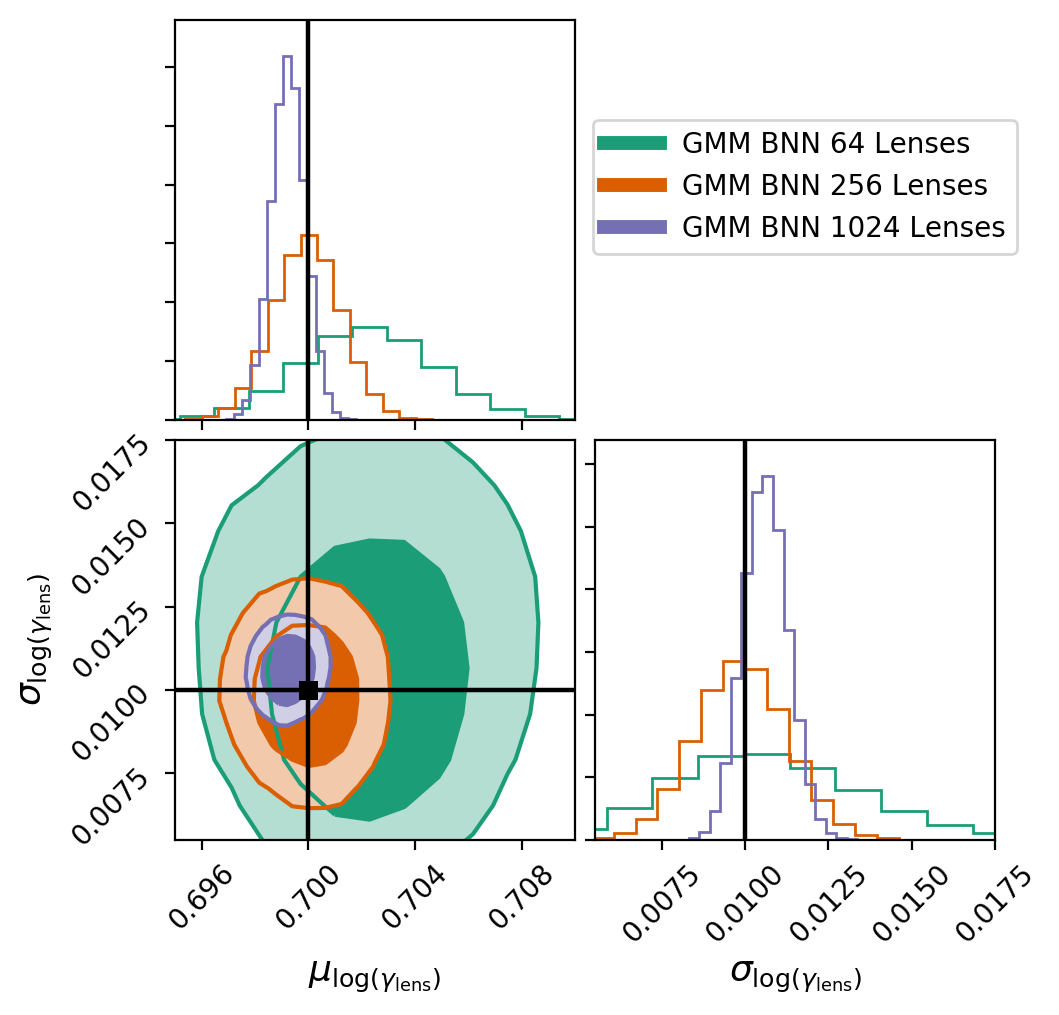

In [51]:
# Plot the two contours with the truth
plot_param = 'lens_mass_gamma'
plot_range = None#[[0.695,0.71],[0.0055,0.0175]]
figure = hier_infer_nn3_slr_64.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr_256.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Modify the axis limits manually to get all the posteriors
figure.axes[0].set_xlim([0.695,0.71])
figure.axes[2].set_xlim([0.695,0.71])
figure.axes[2].set_ylim([0.0055,0.0175])
figure.axes[3].set_xlim([0.0055,0.0175])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN 64 Lenses', r'GMM BNN 256 Lenses',r'GMM BNN 1024 Lenses'],
              loc=(0.56,0.75))
plt.savefig('figures/cn_gamma_lens_2d_hyps_nl.pdf')
plt.show(figure)

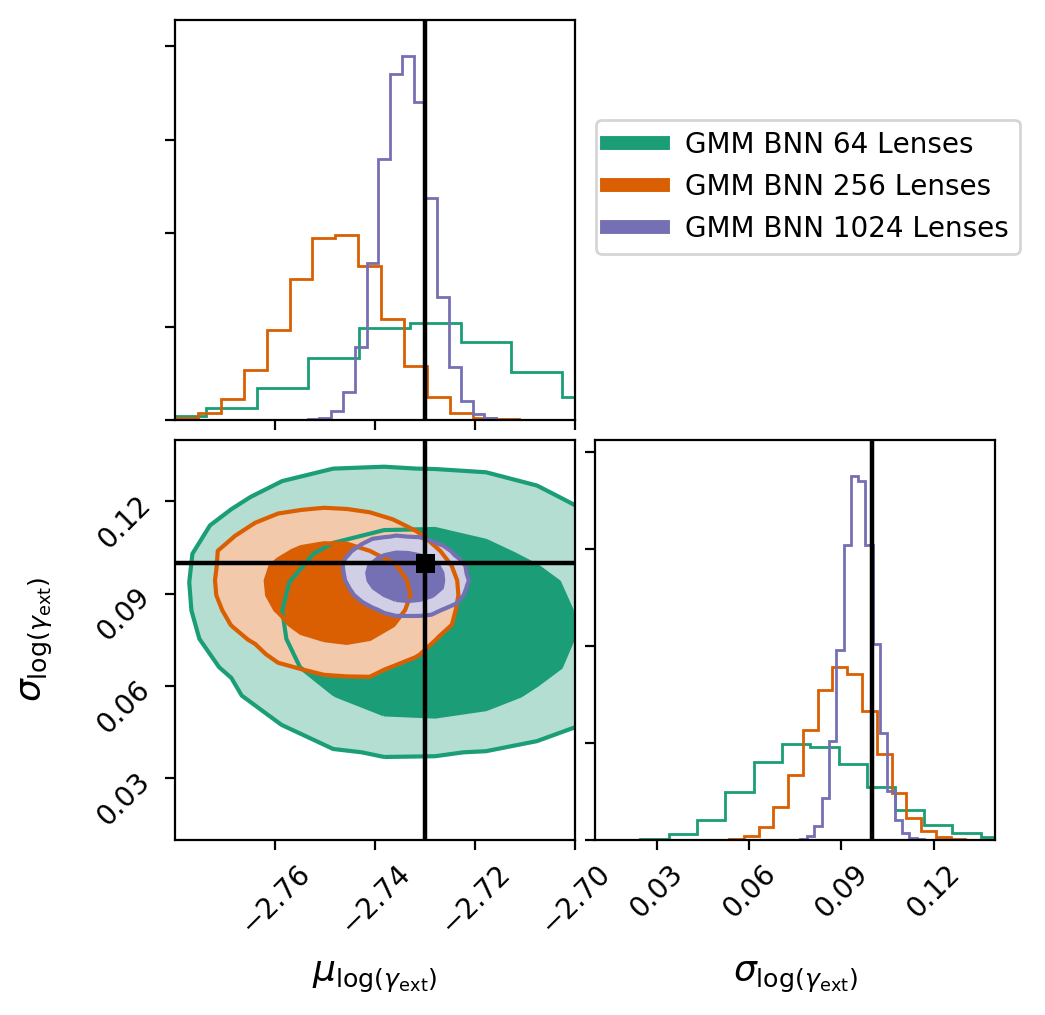

In [52]:
# Plot the two contours with the truth
plot_param = 'external_shear_gamma_ext'
plot_range = None#[[0.695,0.71],[0.0055,0.0175]]
figure = hier_infer_nn3_slr_64.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#1b9e77',
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr_256.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#d95f02',figure=figure,
                                           plot_range=plot_range)
figure = hier_infer_nn3_slr.plot_single_corner(burnin,plot_param,hyperparam_plot_names,color='#7570b3',figure=figure,
                                           plot_range=plot_range)

# Modify the axis limits manually to get all the posteriors
figure.axes[0].set_xlim([-2.78,-2.7])
figure.axes[2].set_xlim([-2.78,-2.7])
figure.axes[2].set_ylim([0.01,0.14])
figure.axes[3].set_xlim([0.01,0.14])

# Do some nice work to make a legend
handles = [Line2D([0], [0], color='#1b9e77', lw=5),
           Line2D([0], [0], color='#d95f02', lw=5),
           Line2D([0], [0], color='#7570b3', lw=5)]
figure.legend(handles,[r'GMM BNN 64 Lenses', r'GMM BNN 256 Lenses',r'GMM BNN 1024 Lenses'],
              loc=(0.57,0.75))
plt.savefig('figures/cn_gamma_ext_2d_hyps_nl.pdf')
plt.show(figure)